# Pre-Start Procedures

## Import Statements (Always Run)

In [1]:
# customary imports:
import tensorflow as tf
assert '2.' in tf.__version__  # make sure you're using tf 2.0
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math, string, random, datetime
import os, shutil, h5py, copy, re
import requests, zipfile, io
import skimage
import scipy
from skimage import exposure
import seaborn as sns
import PIL
import imageio
if 'COLAB_GPU' in os.environ:
    # Load the Drive helper and mount
    from google.colab import drive
    # This will prompt for authorization.
    drive.mount('/content/drive')
    
else:
    import utils.preprocess_crop
from pathlib import Path
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
print('Tensorflow version: ' + tf.__version__)
if tf.__version__ == '2.2.0':
    import tensorflow_addons as tfa
%matplotlib inline
%load_ext autoreload
%autoreload 2

Tensorflow version: 2.11.0


# Download and Seperate Data into Train/Val/Test

## To Download the Vessel Dataset From Online (Preprocessing is already done):

In [4]:
DATA_DIR = 'combined_vessel_data'
ZIP_FILE_URL = 'https://ndownloader.figshare.com/articles/12871805/versions/1'

In [ ]:
print('Downloading Files...')
if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)
    r = requests.get(ZIP_FILE_URL)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(f'./{DATA_DIR}')
print('Files Downloaded')

Files Downloaded


## Function to Seperate Folder into Subfolder of /training /validation and /testing

In [5]:
# Import Statements:
from utils.data_preprocessing_utils import data_seperation

In [6]:
input_dir = DATA_DIR
output_dir = 'data'
delete_previous = True
file_format = '.PNG'
dataset_percentages = (80, 10, 10)

print('Starting Data Seperation...')
train_dir, val_dir, test_dir = data_seperation(input_dir, output_dir, dataset_percentages, 
                                               delete_previous, file_format)
print('Ending Data Seperation')

Starting Data Seperation...
Ending Data Seperation


### Code Block to Show How Much of Data has been Placed in various Subfolders (train/val/test)

In [7]:
# print('Length of raw_data directory = '+str(len(os.listdir('raw_data'))))
# print('Length of converted_data directory = '+str(len(os.listdir('converted_data'))))
# print('Rejected Files = ' + str(len(os.listdir('raw_data')) - len(os.listdir('converted_data'))))
print('Length of training directory = '+str(len(os.listdir(train_dir))))
print('Length of validation directory = '+str(len(os.listdir(val_dir))))
print('Length of test directory = '+str(len(os.listdir(test_dir))))

Length of training directory = 304
Length of validation directory = 39
Length of test directory = 38


# Data Loading

## Padding Training Data and Adding Downsampled Image as Channel

In [8]:
# Import Statements:
from utils.standardize_dir_utils import pad_img_and_add_down_channel
from utils.standardize_dir_utils import standardize_dir

In [9]:
main_dir = 'data'
STANDARD_IMAGE_SHAPE = (128,128,1)
downsample_axis = 'both'
downsample_ratio = [1,5]
file_format = '.PNG'

In [10]:
input_dir = main_dir + '/train/input'
total_train_image_pool = standardize_dir(input_dir, downsample_axis, downsample_ratio, 
                                         STANDARD_IMAGE_SHAPE, file_format)
print('total_train_image_pool = ' + str(total_train_image_pool))

total_train_image_pool = 304


In [11]:
input_dir = main_dir + '/val/input'
total_val_image_pool = standardize_dir(input_dir, downsample_axis, downsample_ratio, 
                                       STANDARD_IMAGE_SHAPE, file_format)
print('total_val_image_pool = ' + str(total_val_image_pool))

total_val_image_pool = 39


In [12]:
input_dir = main_dir + '/test/input'
total_test_image_pool = standardize_dir(input_dir, downsample_axis, downsample_ratio, 
                                        STANDARD_IMAGE_SHAPE, file_format)
print('total_test_image_pool = ' + str(total_test_image_pool))

total_test_image_pool = 38


# Model Testing and Training - Run After this Point if Restarting Kernel (and you have re-run the import statements)

## Data Loader and Augmentation

In [13]:
from utils.data_aug_funcs import preprocess_function
from utils.data_aug_funcs import preprocess_function_valtest

In [14]:
STANDARD_IMAGE_SHAPE = (128,128,1) # See Above Section to Verify Shape
MIN_SHAPE = (STANDARD_IMAGE_SHAPE[0],STANDARD_IMAGE_SHAPE[1])
BATCH_SIZE = 16
main_dir = 'data'
train_dir = main_dir + '/train'
val_dir = main_dir + '/val'
test_dir = main_dir + '/test'
seed = 7
tf.random.set_seed(seed)

In [15]:
data_gen_args_train = dict(horizontal_flip=True,
                           vertical_flip = True,
                           rotation_range=20,
                           width_shift_range=0.1,#0.2
                           height_shift_range=0.1,#0.2
                           shear_range=0.2,#0.2
                           fill_mode='constant',
                           cval=0,
                           preprocessing_function=preprocess_function,
                           dtype='float32')
train_datagen = ImageDataGenerator(**data_gen_args_train)


data_gen_args_test_and_val = dict(preprocessing_function = preprocess_function_valtest)
test_and_val_datagen = ImageDataGenerator(**data_gen_args_test_and_val)
# Flow From Directory Generators
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=MIN_SHAPE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode=None,
                                                    ####################
                                                    # Monkey Patch - utils.preprocess_crop.py
                                                    interpolation = 'lanczos', #:random
                                                    ####################
                                                    color_mode='rgb',
                                                    shuffle = True, 
                                                    seed=seed)

validation_generator = test_and_val_datagen.flow_from_directory(val_dir,
                                                                target_size=MIN_SHAPE,
                                                                batch_size=BATCH_SIZE,
                                                                class_mode=None,
                                                                ####################
                                                                # Monkey Patch - utils.preprocess_crop.py
                                                                interpolation = 'lanczos',
                                                                ####################
                                                                color_mode='rgb',
                                                                shuffle = True, 
                                                                seed=seed)
test_generator = test_and_val_datagen.flow_from_directory(test_dir,
                                                          target_size=MIN_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode=None,
                                                          ####################
                                                          # Monkey Patch - utils.preprocess_crop.py
                                                          interpolation = 'lanczos', 
                                                          ####################
                                                          color_mode='rgb', 
                                                          shuffle = False,
                                                          seed=seed)

Found 304 images belonging to 1 classes.
Found 39 images belonging to 1 classes.
Found 38 images belonging to 1 classes.


In [16]:
def custom_generator_wrapper(gen):
    '''
    This wrapper function ensures that the downsampled data and ground truth
    stay coaligned during the random crop step.
    '''
    for data in gen:
        orig_img = data[...,0] # target
        down_img = data[...,1] # input
        # Third channel has mask
        yield down_img[..., None], orig_img[..., None]

## Model Definition for U-Net

In [17]:
# Various Models:
#from models.UNet import getModel
#from models.Res_UNet import getModel
#from models.ResICL_UNet import getModel
#from models.FD_UNet import getModel
from models.FD_UNet_SpatialDropout import getModel

from utils.model_utils import model_loss
from utils.model_utils import PSNR
from utils.model_utils import SSIM
from utils.model_utils import KLDivergence
from utils.model_utils import SavingMetric
from utils.model_utils import model_loss_experimental

### Hyperparameters

In [18]:
# Hyperparameters:
EPOCHS = 10
FILTERS = 64
INITIAL_LR = 0.005
ACTIVATION = 'elu'       
KERNEL_SIZE = 3 # 3x3 kernel
AUGMENTATIONS = 10
VAL_AUGMENTATIONS = 10
USE_MSE = True
PROB = 0.05

if USE_MSE:
    B1 = 1.0
    B2 = 0.000075#0.000075
    B3 = 0.001#0.001#0.002#0.001
else: 
    # MAE
    B1 = 1.0
    B2 = 0.0025
    B3 = 0.005

# Loss functions and Metrics:
saving_metric = 'val_loss' # 'val_SavingMetric'
saving_metric_2 = 'val_ssim_psnr'
loss_func = model_loss_experimental(B1,B2,B3, mse = USE_MSE) # loss=model_loss(B1,B2)
fourier_loss = model_loss(B1=0.0, B2=1.0, name='fourier_loss')
ssim_psnr = model_loss_experimental(B1=0, B2=0, B3=1.0, mse = USE_MSE, name='ssim_psnr')

# Directories and Dir Protecols:
train_dir = main_dir + '/train/input'
val_dir = main_dir + '/val/input'
model_dir = 'model_dir'
model_dir_ssim_psnr = 'model_dir_ssim_psnr'
delete_previous = True

### Compiling and Training Model

In [19]:
# Functional API Model
if getModel.__name__ not in ['FD_UNet_Model', 'FD_UNet_Model_Spatial_Dropout', 'ResICL_UNet_Model']:
    unet_model = getModel(input_shape=STANDARD_IMAGE_SHAPE, filters=FILTERS, kernel_size=KERNEL_SIZE, activation=ACTIVATION)
elif getModel.__name__ is 'FD_UNet_Model':
    unet_model = getModel(input_shape=STANDARD_IMAGE_SHAPE, filters=FILTERS//2, kernel_size=KERNEL_SIZE, activation=ACTIVATION)
elif getModel.__name__ is 'ResICL_UNet_Model':
    unet_model = getModel(input_shape=STANDARD_IMAGE_SHAPE, filters=FILTERS, kernel_size=KERNEL_SIZE, activation=ACTIVATION, prob=PROB)
else:
    # IF FD-UNET With Spatial Dropout
    unet_model = getModel(input_shape=STANDARD_IMAGE_SHAPE, filters=FILTERS//2, kernel_size=KERNEL_SIZE, activation=ACTIVATION, prob=PROB)

In [20]:
#unet_model = saved_model
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR, amsgrad=False),  # pick an optimizer
                   loss=loss_func,
                   metrics=['mean_absolute_error', 'mean_squared_error', 
                            fourier_loss, PSNR, SSIM, ssim_psnr])

In [21]:
if not os.path.exists(model_dir):
            os.mkdir(model_dir)
elif delete_previous:
            shutil.rmtree(model_dir)
            os.mkdir(model_dir)
if not os.path.exists(model_dir_ssim_psnr):
            os.mkdir(model_dir_ssim_psnr)
elif delete_previous:
            shutil.rmtree(model_dir_ssim_psnr)
            os.mkdir(model_dir_ssim_psnr)

my_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(model_dir, 'saved_model.epoch_{epoch:02d}-SSIM_{val_SSIM:.5f}-PSNR_{val_PSNR:.5f}-metric_{'+f'{saving_metric}'+':.5f}.h5'),
                                                   monitor=saving_metric,
                                                   verbose=0, 
                                                   save_best_only=True, save_weights_only=False, 
                                                   mode='min', save_freq='epoch'),
                tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(model_dir_ssim_psnr, 'saved_model.epoch_{epoch:02d}-SSIM_{val_SSIM:.5f}-PSNR_{val_PSNR:.5f}-metric_{'+f'{saving_metric}'+':.5f}.h5'),
                                                   monitor=saving_metric_2,
                                                   verbose=0, 
                                                   save_best_only=True, save_weights_only=False, 
                                                   mode='min', save_freq='epoch')]

history = unet_model.fit(custom_generator_wrapper(train_generator),
                         steps_per_epoch=AUGMENTATIONS*np.ceil(len(os.listdir(train_dir))/BATCH_SIZE),
                         epochs=EPOCHS,
                         callbacks=my_callbacks, 
                         validation_data=custom_generator_wrapper(validation_generator),
                         validation_steps=VAL_AUGMENTATIONS*np.ceil(len(os.listdir(val_dir))/BATCH_SIZE), 
                         max_queue_size=AUGMENTATIONS*np.ceil(len(os.listdir(train_dir))/BATCH_SIZE),
                         shuffle=True)

Epoch 1/10


### Load the Best Model From Model Dir

In [30]:
from utils.model_utils import model_loss
from utils.model_utils import model_loss_experimental
from utils.model_utils import PSNR
from utils.model_utils import SSIM
from utils.model_utils import KLDivergence
from utils.model_utils import SavingMetric
print('Loading Best Model...')
model_dir = 'model_dir'
file_list = [file for file in os.listdir(model_dir) if os.path.isfile(os.path.join(model_dir, file))]
filename = sorted(file_list, key = lambda x : int(x.partition('h_')[2].partition('-S')[0]))[-1]
directory = os.path.join(os.getcwd(), model_dir)
directory = os.path.join(directory, filename)
unet_model = tf.keras.models.load_model(directory, compile=False) # To Fine-Tune
'''
if 'USE_MSE' not in locals() and 'USE_MSE' not globals():
    USE_MSE = True
fourier_loss = model_loss(B1=0.0, B2=1.0, name='fourier_loss')
save_func = model_loss_experimental(B1=0,B2=0,B3=1, mse = USE_MSE, name='save_func')
ssim_psnr = model_loss_experimental(B1=0,B2=0,B3=1, mse = USE_MSE, name='ssim_psnr')
saved_model = tf.keras.models.load_model(directory, custom_objects={'model_loss':model_loss,'loss_func':model_loss(B1=0.99,B2=0.01), 
                                                                    'PSNR':PSNR, 'SSIM':SSIM, 'KLDivergence':KLDivergence, 
                                                                    'SavingMetric':SavingMetric, 'fourier_loss':fourier_loss, 
                                                                    'save_func':save_func, 'ssim_psnr':ssim_psnr})
#'''
print('Done Loading Best Model (' + filename + ') from: ' + model_dir)

Loading Best Model...
Done Loading Best Model (saved_model.epoch_03-SSIM_0.16326-PSNR_8.89635-metric_3.57631.h5) from: model_dir


### Load the Best Model From Model Dir (SSIM-PSNR)

In [31]:
from utils.model_utils import model_loss
from utils.model_utils import model_loss_experimental
from utils.model_utils import PSNR
from utils.model_utils import SSIM
from utils.model_utils import KLDivergence
from utils.model_utils import SavingMetric
print('Loading Best Model...')
model_dir = 'model_dir_ssim_psnr'
file_list = [file for file in os.listdir(model_dir) if os.path.isfile(os.path.join(model_dir, file))]
filename = sorted(file_list, key = lambda x : int(x.partition('h_')[2].partition('-S')[0]))[-1]
directory = os.path.join(os.getcwd(), model_dir)
directory = os.path.join(directory, filename)
#unet_model = tf.keras.models.load_model(directory, compile=False) # To Fine-Tune
#'''
if 'USE_MSE' not in locals() and 'USE_MSE' not in globals():
    USE_MSE = True
fourier_loss = model_loss(B1=0.0, B2=1.0, name='fourier_loss')
save_func = model_loss_experimental(B1=0,B2=0,B3=1, mse = USE_MSE, name='save_func')
ssim_psnr = model_loss_experimental(B1=0,B2=0,B3=1, mse = USE_MSE, name='ssim_psnr')
saved_model = tf.keras.models.load_model(directory, custom_objects={'model_loss':model_loss,'loss_func':model_loss(B1=0.99,B2=0.01), 
                                                                    'PSNR':PSNR, 'SSIM':SSIM, 'KLDivergence':KLDivergence, 
                                                                    'SavingMetric':SavingMetric, 'fourier_loss':fourier_loss, 
                                                                    'save_func':save_func, 'ssim_psnr':ssim_psnr})
#'''
print('Done Loading Best Model (' + filename + ') from: ' + model_dir)

Loading Best Model...
Done Loading Best Model (saved_model.epoch_03-SSIM_0.16326-PSNR_8.89635-metric_3.57631.h5) from: model_dir_ssim_psnr


## Analysis of Model Training History

In [14]:
from utils.history_utils import show_history

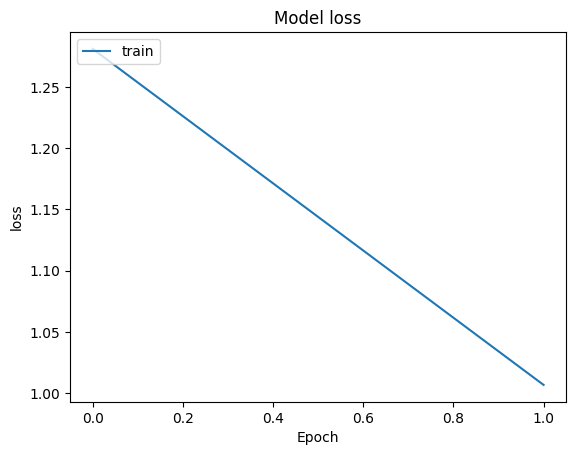

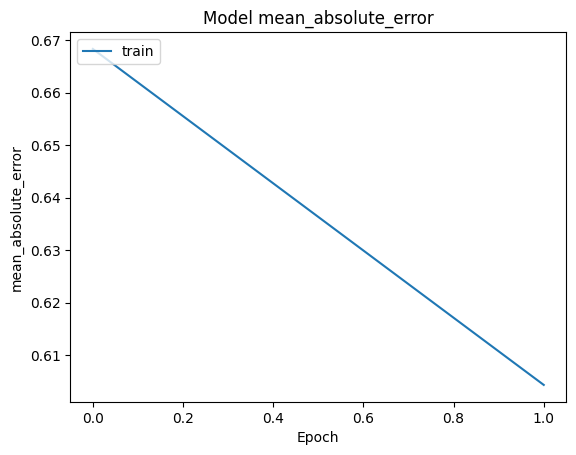

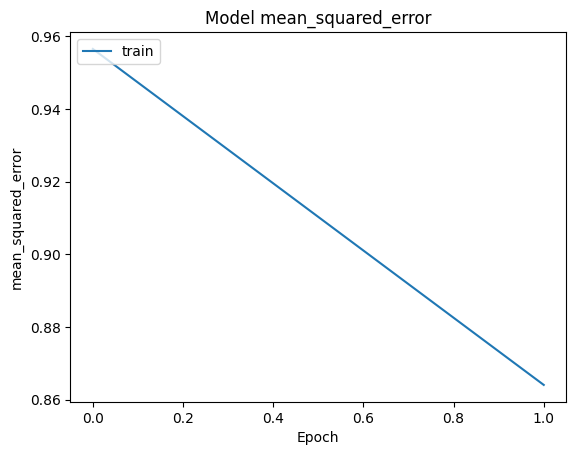

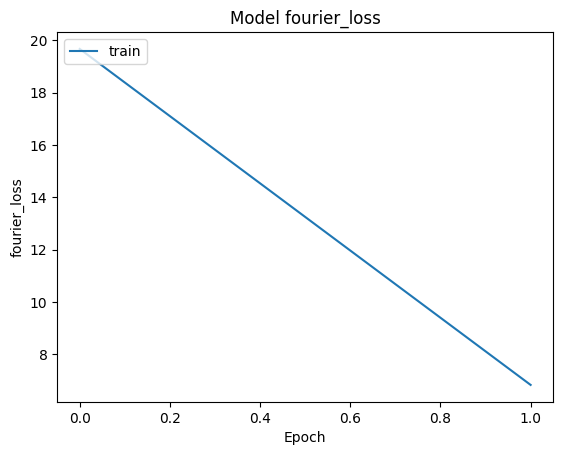

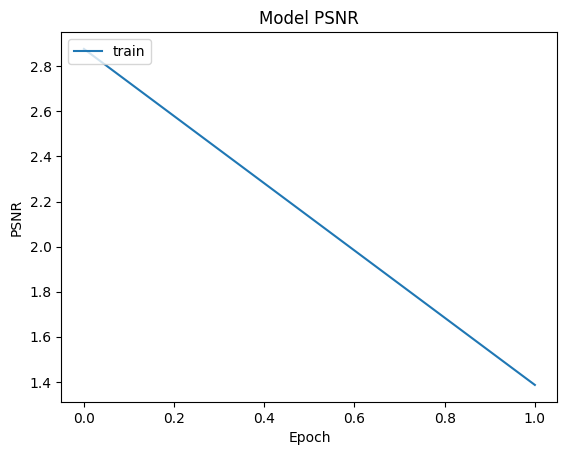

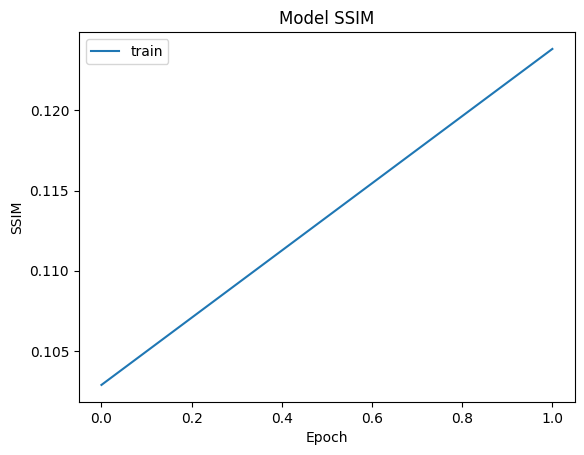

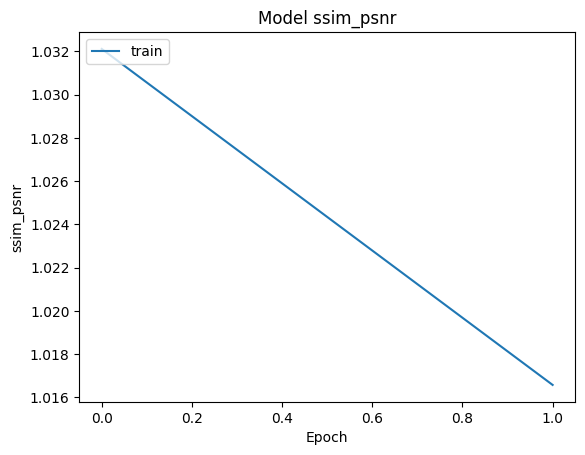

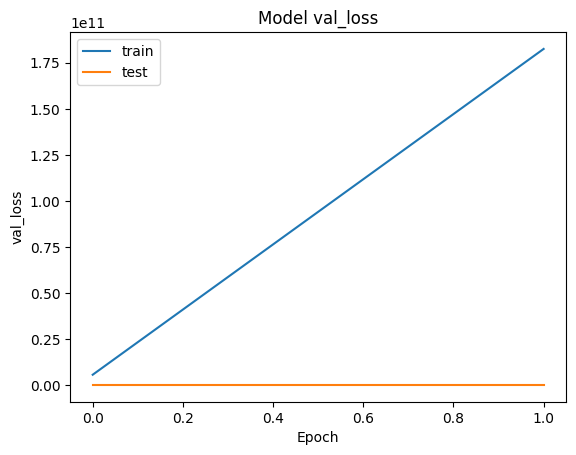

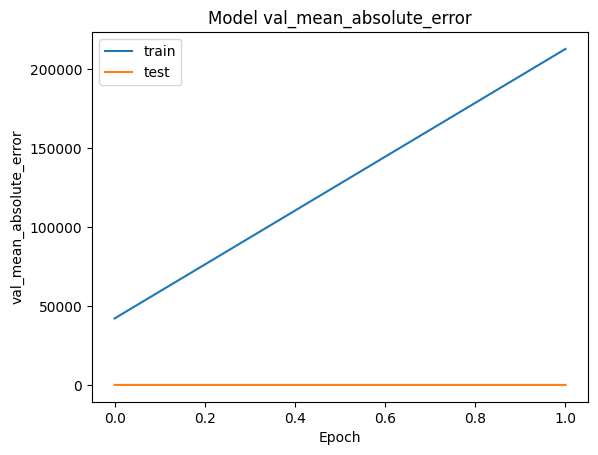

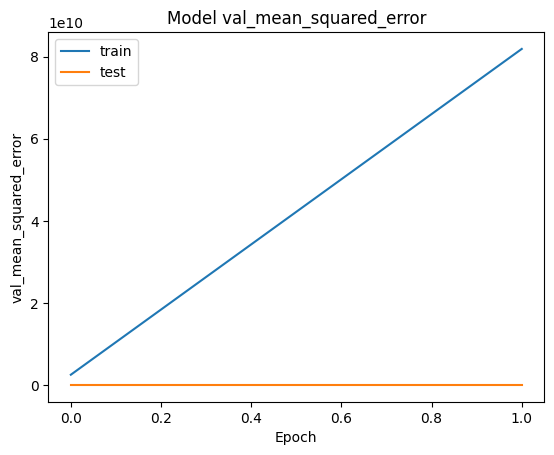

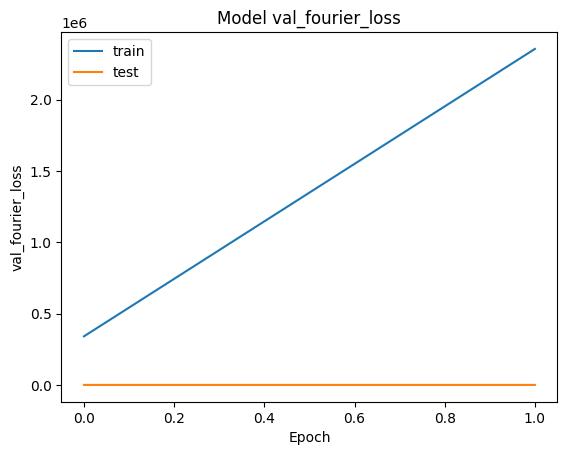

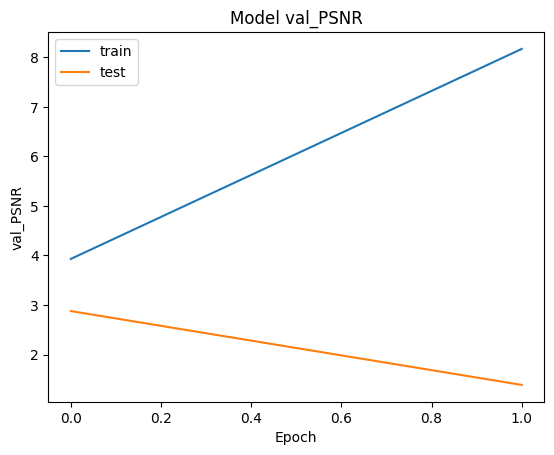

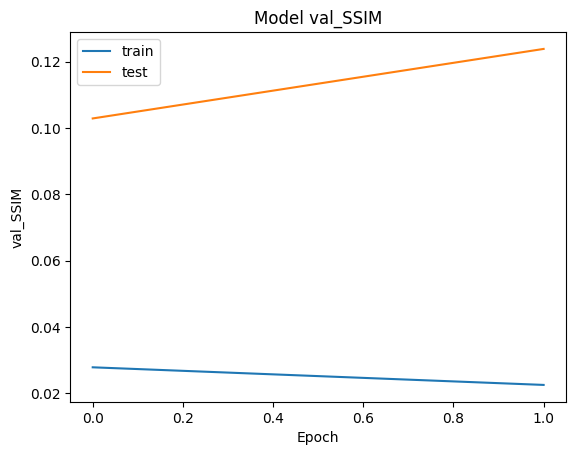

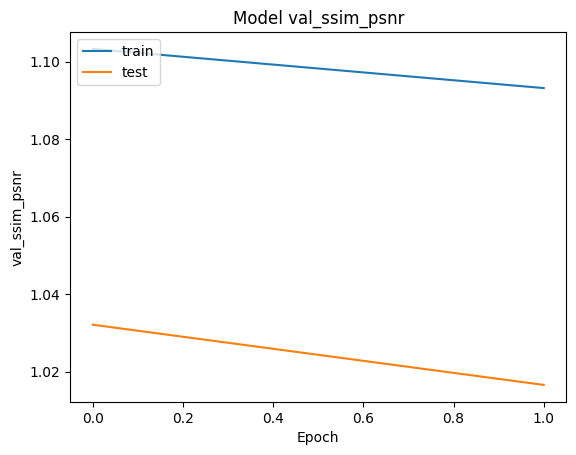

In [15]:
offset = 0
show_history(history, offset=0)

### Model Architecture

In [ ]:
unet_model.summary()

In [ ]:
# To Show Model Graph:
# tf.keras.utils.plot_model(unet_model, 'unet_arch_TB.png', show_shapes=True, rankdir='TB', dpi=300)

## Save Model

In [32]:
from utils.save_model_utils import save_model
output_dir = 'saved_model_FD_UNet_5i-10j'
model_dir_list = ['model_dir', 'model_dir_ssim_psnr']
save_model(unet_model, output_dir, model_dir_list)

Directory Already Exists...
Saving Latest Model...
Creating ./model_dir Directory...
Saving Best Model From ./model_dir...
Creating ./model_dir_ssim_psnr Directory...
Saving Best Model From ./model_dir_ssim_psnr...
Done Saving !!!


## Load Model

### For Functional API - Best Model State (can be for Fine-Tuning)

In [34]:
from utils.model_utils import model_loss
from utils.model_utils import model_loss_experimental
from utils.model_utils import PSNR
from utils.model_utils import SSIM
from utils.model_utils import KLDivergence
from utils.model_utils import SavingMetric
print('Loading Model...')
input_dir = 'saved_model_FD_UNet_5i-10j/best_models_from_model_dir_ssim_psnr'
USE_MSE = True
file_list = [file for file in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, file))]
filename = sorted(file_list, key = lambda x : int(x.partition('h_')[2].partition('-S')[0]))[-1]
directory = os.path.join(os.getcwd(), input_dir)
directory = os.path.join(directory, filename)
#unet_model = tf.keras.models.load_model(directory, compile=False) # To Fine-Tune
#'''
fourier_loss = model_loss(B1=0.0, B2=1.0, name='fourier_loss')
save_func = model_loss_experimental(B1=0,B2=0,B3=1, mse = USE_MSE, name='save_func')
ssim_psnr = model_loss_experimental(B1=0,B2=0,B3=1, mse = USE_MSE, name='ssim_psnr')
saved_model = tf.keras.models.load_model(directory, custom_objects={'model_loss':model_loss,'loss_func':model_loss(B1=0.99,B2=0.01), 
                                                                    'PSNR':PSNR, 'SSIM':SSIM, 'KLDivergence':KLDivergence, 
                                                                    'SavingMetric':SavingMetric, 'fourier_loss':fourier_loss, 
                                                                    'save_func':save_func, 'ssim_psnr':ssim_psnr})
#''' 
print('Done Loading Best Model (' + filename + ') from: ' + input_dir)

Loading Model...
Done Loading Best Model (saved_model.epoch_03-SSIM_0.16326-PSNR_8.89635-metric_3.57631.h5) from: saved_model_FD_UNet_5i-10j/best_models_from_model_dir_ssim_psnr


### For Functional API - Latest Model State (can be for Fine-Tuning)

In [35]:
from utils.model_utils import model_loss
from utils.model_utils import model_loss_experimental
from utils.model_utils import PSNR
from utils.model_utils import SSIM
from utils.model_utils import KLDivergence
from utils.model_utils import SavingMetric
print('Loading Model...')
input_dir = 'saved_model_FD_UNet_5i-10j'
USE_MSE = True
filename = 'saved_model.h5'
directory = os.path.join(os.getcwd(), input_dir)
directory = os.path.join(directory, filename)
#unet_model = tf.keras.models.load_model(directory, compile=False) # To Fine-Tune
#'''
fourier_loss = model_loss(B1=0.0, B2=1.0, name='fourier_loss')
save_func = model_loss_experimental(B1=0,B2=0,B3=1, mse = USE_MSE, name='save_func')
ssim_psnr = model_loss_experimental(B1=0,B2=0,B3=1, mse = USE_MSE, name='ssim_psnr')
saved_model = tf.keras.models.load_model(directory, custom_objects={'model_loss':model_loss,'loss_func':model_loss(B1=0.99,B2=0.01), 
                                                                    'PSNR':PSNR, 'SSIM':SSIM, 'KLDivergence':KLDivergence, 
                                                                    'SavingMetric':SavingMetric, 'fourier_loss':fourier_loss, 
                                                                    'save_func':save_func, 'ssim_psnr':ssim_psnr})
#'''                                                                    
print('Done Loading Latest Model ' + filename + ' from: ' + input_dir)

Loading Model...
Done Loading Latest Model saved_model.h5 from: saved_model_FD_UNet_5i-10j


### Load History From File And Display

In [36]:
from utils.history_utils import load_history_from_saved
from utils.history_utils import show_history

input_dir = 'saved_model_FD_UNet_5i-10j'
saved_hist = load_history_from_saved(input_dir)
show_history(saved_hist)

FileNotFoundError: [Errno 2] No such file or directory: 'd:\\Thesis\\saved_model_FD_UNet_5i-10j\\history.npz'

# Showing Results with Test Images (Zero-Fill Method):

## Load Model

In [ ]:
from utils.model_utils import model_loss
from utils.model_utils import model_loss_experimental
from utils.model_utils import PSNR
from utils.model_utils import SSIM
from utils.model_utils import KLDivergence
from utils.model_utils import SavingMetric
print('Loading Model...')
input_dir ='saved_model_FD_UNet_5i-10j/best_models_from_model_dir_ssim_psnr'
USE_MSE = True
file_list = [file for file in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, file))]
filename = sorted(file_list, key = lambda x : int(x.partition('h_')[2].partition('-S')[0]))[-1]
directory = os.path.join(os.getcwd(), input_dir)
directory = os.path.join(directory, filename)
fourier_loss = model_loss(B1=0.0, B2=1.0, name='fourier_loss')
save_func = model_loss_experimental(B1=0,B2=0,B3=1, mse = USE_MSE, name='save_func')
ssim_psnr = model_loss_experimental(B1=0,B2=0,B3=1, mse = USE_MSE, name='ssim_psnr')
saved_model = tf.keras.models.load_model(directory, custom_objects={'model_loss':model_loss,'loss_func':model_loss(B1=0.99,B2=0.01), 
                                                                    'PSNR':PSNR, 'SSIM':SSIM, 'KLDivergence':KLDivergence, 
                                                                    'SavingMetric':SavingMetric, 'fourier_loss':fourier_loss, 
                                                                    'save_func':save_func, 'ssim_psnr':ssim_psnr})
print('Done Loading Best Model (' + filename + ') from: ' + input_dir)

## Testing Zero-Fill on Full Images

In [ ]:
# Import Statements
from utils.patchwork_alg import apply_model_patchwork
# Quantitative Measurements
from utils.model_utils import PSNR
from utils.model_utils import SSIM

In [ ]:
dir_name = 'display_image'
file_list = os.listdir(dir_name)   
filename = file_list[0]
filepath = os.path.join(dir_name, filename)
print('Directory: ' + filepath)
downsampling_ratio = [5,10]
orig_img = np.array(imageio.imread(filepath), dtype=np.float32)
full_samp_img = exposure.rescale_intensity(orig_img[...,0], in_range='image', out_range=(0.0,1.0))
'''
# If using color images
if len(img.shape)>2:
    img = np.mean(img, axis = 2)
'''
# To Change Aspect Ratio of Image Before Running Model/Interpolation
i_ratio = 2
j_ratio = 1
full_samp_img_shape = (full_samp_img.shape[0]*i_ratio, full_samp_img.shape[1]*j_ratio)
full_samp_img = skimage.transform.resize(full_samp_img, output_shape=full_samp_img_shape, order=3, 
                                         mode='reflect', cval=0, clip=True, preserve_range=True, 
                                         anti_aliasing=True, anti_aliasing_sigma=None)
latent_image = full_samp_img[::downsampling_ratio[0],::downsampling_ratio[1]]
mask = np.zeros(full_samp_img.shape, dtype=np.int8)
mask[::downsampling_ratio[0], ::downsampling_ratio[1]] = 1
down_image = full_samp_img*mask

In [ ]:
print(latent_image.shape)
figsize = (15,15)
fontsize = 23
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(latent_image, cmap = 'gray')
plt.title('Original Latent Image', fontsize=fontsize)
plt.show()

print(full_samp_img.shape)
figsize = (30,30)
fontsize = 23
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(full_samp_img, cmap = 'gray')
plt.title('Original Full-Sampled Image', fontsize=fontsize)
plt.show()
deep_image = apply_model_patchwork(saved_model, down_image = latent_image, downsampling_ratio = downsampling_ratio, 
                                   downsampling_axis = 'both', shape_for_model = (128,128), 
                                   buffer = 32, output_shape = full_samp_img.shape, interp=False)

'''
# To Perform Contrast Adjustment
deep_image = skimage.img_as_float(deep_image)
p1, p2 = np.percentile(deep_image, (0.01, 99.99))
deep_image = exposure.rescale_intensity(deep_image, in_range=(p1, p2), out_range=(0.0,1.0))
#'''

figsize = (30,30)
fontsize = 23
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(deep_image, cmap = 'gray')
plt.title('Cleaned DL Image', fontsize=fontsize)
plt.show()

# COMPARISON TO INTERPOLATION:
interp_img = skimage.transform.resize(latent_image, output_shape=full_samp_img.shape, 
                                      order=3, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=True, 
                                      anti_aliasing_sigma=None)
print(interp_img.shape)
figsize = (30,30)
fontsize = 23
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(interp_img, cmap = 'gray')
plt.title('Bi-Cubic Interpolation Image', fontsize=fontsize)
plt.show()

# Saving Result Images:
model_name = saved_model.name.replace(' ', '-')
directory = f'{model_name}_figures_{downsampling_ratio[0]}i-{downsampling_ratio[1]}j_down_v4'
print(f'Saving to: {directory}')
if not os.path.exists(directory):
    os.mkdir(directory)
else:
    shutil.rmtree(directory)
    os.mkdir(directory)
filename = 'latent_image.png'
filepath = os.path.join(directory, filename)
latent_image = exposure.rescale_intensity(latent_image, in_range='image', out_range=(0,255)).astype(np.uint8)
imageio.imwrite(filepath, latent_image, format='.png', compress_level=0)
filename = 'deep_image.png'
filepath = os.path.join(directory, filename)
deep_image = exposure.rescale_intensity(deep_image, in_range='image', out_range=(0,255)).astype(np.uint8)
imageio.imwrite(filepath, deep_image, format='.png', compress_level=0)
filename = 'interp_img.png'
filepath = os.path.join(directory, filename)
interp_img = exposure.rescale_intensity(interp_img, in_range='image', out_range=(0,255)).astype(np.uint8)
imageio.imwrite(filepath, interp_img, format='.png', compress_level=0)
filename = 'full_sample_img.png'
filepath = os.path.join(directory, filename)
full_samp_img = exposure.rescale_intensity(full_samp_img, in_range='image', out_range=(0,255)).astype(np.uint8)
imageio.imwrite(filepath, full_samp_img, format='.png', compress_level=0)
filename = 'down_image.png'
filepath = os.path.join(directory, filename)
down_image = exposure.rescale_intensity(down_image, in_range='image', out_range=(0,255)).astype(np.uint8)
imageio.imwrite(filepath, down_image, format='.png', compress_level=0)

### Showing and Saving Cropped Image Results

In [ ]:
# Saving Result Images:

'''
IMAGE 1:
'''

ratio_0 = 1025/1280
ratio_1 = 720/1280
ratio_2 = 740/2048
ratio_3 = 430/2048

filename = 'down_image_crop_1.png'
filepath = os.path.join(directory, filename)
shape = full_samp_img.shape
down_image_crop = down_image[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                             int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, down_image_crop, format='.png', compress_level=0)
filename = 'deep_image_crop_1.png'
filepath = os.path.join(directory, filename)
deep_image_crop = deep_image[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                             int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, deep_image_crop, format='.png', compress_level=0)
filename = 'interp_img_crop_1.png'
filepath = os.path.join(directory, filename)
interp_img_crop = interp_img[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                             int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, interp_img_crop, format='.png', compress_level=0)
filename = 'latent_image_crop_1.png'
filepath = os.path.join(directory, filename)
latent_shape = latent_image.shape
latent_image_crop = latent_image[int(latent_shape[0]-(ratio_0*latent_shape[0])):int(latent_shape[0]-(ratio_1*latent_shape[0])),
                             int(latent_shape[1]-(ratio_2*latent_shape[1])):int(latent_shape[1]-(ratio_3*latent_shape[1]))]
imageio.imwrite(filepath, latent_image_crop, format='.png', compress_level=0)
filename = 'latent_image_crop_resized_1.png'
filepath = os.path.join(directory, filename)
latent_image_crop_resized = skimage.transform.resize(latent_image_crop, output_shape=down_image_crop.shape, 
                                                     order=1, mode='reflect', cval=0, clip=True, preserve_range=True, 
                                                     anti_aliasing=True, anti_aliasing_sigma=None)
latent_image_crop_resized = exposure.rescale_intensity(latent_image_crop_resized, in_range='image', out_range=(0,255)).astype(np.uint8)
imageio.imwrite(filepath, latent_image_crop_resized, format='.png', compress_level=0)
filename = 'full_img_crop_1.png'
filepath = os.path.join(directory, filename)
full_samp_img_crop = full_samp_img[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                                   int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, full_samp_img_crop, format='.png', compress_level=0)

'''
Displaying Images:
'''
figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(down_image_crop, cmap = 'gray')
plt.title('Downsampled Image Crop 1', fontsize=fontsize)
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(latent_image_crop, cmap = 'gray')
plt.title('Latent Image Crop 1', fontsize=fontsize)
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(latent_image_crop_resized, cmap = 'gray')
plt.title('Latent Image Crop Resized 1', fontsize=fontsize)
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(full_samp_img_crop, cmap = 'gray')
plt.title('Original Fully-Sampled Image Crop 1', fontsize=fontsize)
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(deep_image_crop, cmap = 'gray')
plt.title('DL Reconstruction Crop 1', fontsize=fontsize)
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(interp_img_crop, cmap = 'gray')
plt.title('Bicubic Interpolation Crop 1', fontsize=fontsize)
plt.show()

'''
Showing Vessel Profiles:
'''

DISP_CONV_FACTOR = 5 # converts pixels to micron

angle = -20
interp_crop = interp_img_crop[:interp_img_crop.shape[0]//3, 
                              :interp_img_crop.shape[1]//3]
interp_crop = skimage.transform.rotate(interp_crop, angle)
dl_crop = deep_image_crop[:deep_image_crop.shape[0]//3, 
                          :deep_image_crop.shape[1]//3]
dl_crop = skimage.transform.rotate(dl_crop, angle)
full_crop = full_samp_img_crop[:full_samp_img_crop.shape[0]//3, 
                               :full_samp_img_crop.shape[1]//3]
full_crop = skimage.transform.rotate(full_crop, angle)

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0.14,0.14,0.8,0.8])
y_shape = full_crop.shape[0]
x_shape = full_crop.shape[1]
ax.plot(np.arange(0, 40, 1)*DISP_CONV_FACTOR, full_crop[55, 22:62], 
        np.arange(0, 40, 1)*DISP_CONV_FACTOR, interp_crop[55, 22:62],
        np.arange(0, 40, 1)*DISP_CONV_FACTOR, dl_crop[55, 22:62])
ax.legend(['Ground Truth', 'Bicubic', 'Deep Learning'], prop={'size': 15})
plt.xlabel('Distance ($\mu$m)', fontsize=fontsize)
plt.ylabel('Normalized PA Amplitude', fontsize=fontsize)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
filename = 'vessel_compare_1.png'
filepath = os.path.join(directory, filename)
plt.savefig(filepath, dpi=100)
plt.show()

angle = -40
interp_crop = interp_img_crop[:interp_img_crop.shape[0]//3, 
                              2*interp_img_crop.shape[1]//3:]
interp_crop = skimage.transform.rotate(interp_crop, angle)
dl_crop = deep_image_crop[:deep_image_crop.shape[0]//3, 
                          2*deep_image_crop.shape[1]//3:]
dl_crop = skimage.transform.rotate(dl_crop, angle)
full_crop = full_samp_img_crop[:full_samp_img_crop.shape[0]//3, 
                               2*full_samp_img_crop.shape[1]//3:]
full_crop = skimage.transform.rotate(full_crop, angle)
figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0.14,0.14,0.8,0.8])
y_shape = full_crop.shape[0]
x_shape = full_crop.shape[1]
ax.plot(np.arange(0, 30, 1)*DISP_CONV_FACTOR, full_crop[67, 22:52], 
        np.arange(0, 30, 1)*DISP_CONV_FACTOR, interp_crop[67, 22:52],
        np.arange(0, 30, 1)*DISP_CONV_FACTOR, dl_crop[67, 22:52])
ax.legend(['Ground Truth', 'Bicubic', 'Deep Learning'], prop={'size': 15})
plt.xlabel('Distance ($\mu$m)', fontsize=fontsize)
plt.ylabel('Normalized PA Amplitude', fontsize=fontsize)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
filename = 'vessel_compare_2.png'
filepath = os.path.join(directory, filename)
plt.savefig(filepath, dpi=100)
plt.show()

In [ ]:
'''
IMAGE 2:
'''
ratio_0 = 1025/1280
ratio_1 = 720/1280
ratio_2 = 1405/2048
ratio_3 = 1100/2048

filename = 'down_image_crop_2.png'
filepath = os.path.join(directory, filename)
shape = full_samp_img.shape
latent_shape = latent_image.shape
down_image_crop = down_image[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                             int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, down_image_crop, format='.png', compress_level=0)
filename = 'deep_image_crop_2.png'
filepath = os.path.join(directory, filename)
shape = full_samp_img.shape
latent_shape = latent_image.shape
deep_image_crop = deep_image[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                             int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, deep_image_crop, format='.png', compress_level=0)
filename = 'interp_img_crop_2.png'
filepath = os.path.join(directory, filename)
interp_img_crop = interp_img[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                             int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, interp_img_crop, format='.png', compress_level=0)
filename = 'latent_image_crop_2.png'
filepath = os.path.join(directory, filename)
latent_image_crop = latent_image[int(latent_shape[0]-(ratio_0*latent_shape[0])):int(latent_shape[0]-(ratio_1*latent_shape[0])),
                             int(latent_shape[1]-(ratio_2*latent_shape[1])):int(latent_shape[1]-(ratio_3*latent_shape[1]))]
imageio.imwrite(filepath, latent_image_crop, format='.png', compress_level=0)
filename = 'latent_image_crop_resized_2.png'
filepath = os.path.join(directory, filename)
latent_image_crop_resized = skimage.transform.resize(latent_image_crop, output_shape=down_image_crop.shape, 
                                                     order=1, mode='reflect', cval=0, clip=True, preserve_range=True, 
                                                     anti_aliasing=True, anti_aliasing_sigma=None)
latent_image_crop_resized = exposure.rescale_intensity(latent_image_crop_resized, in_range='image', out_range=(0,255)).astype(np.uint8)
imageio.imwrite(filepath, latent_image_crop_resized, format='.png', compress_level=0)
filename = 'full_img_crop_2.png'
filepath = os.path.join(directory, filename)
full_samp_img_crop = full_samp_img[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                                   int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, full_samp_img_crop, format='.png', compress_level=0)


'''
Displaying Images:
'''

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(down_image_crop, cmap = 'gray')
plt.title('Downsampled Image Crop 2', fontsize=fontsize)
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(latent_image_crop, cmap = 'gray')
plt.title('Latent Image Crop 2', fontsize=fontsize)
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(latent_image_crop_resized, cmap = 'gray')
plt.title('Latent Image Crop Resized 2', fontsize=fontsize)
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(full_samp_img_crop, cmap = 'gray')
plt.title('Original Fully-Sampled Image Crop 2', fontsize=fontsize)
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(deep_image_crop, cmap = 'gray')
plt.title('DL Reconstruction Crop 2', fontsize=fontsize)
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(interp_img_crop, cmap = 'gray')
plt.title('Bicubic Interpolation Crop 2', fontsize=fontsize)
plt.show()

'''
Showing Vessel Profiles:
'''

DISP_CONV_FACTOR = 5 # converts pixels to micron

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
y_shape = full_samp_img_crop.shape[0]
x_shape = full_samp_img_crop.shape[1]
ax.plot(np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, full_samp_img_crop[:, x_shape//2]/255, 
        np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, interp_img_crop[:, x_shape//2]/255,
        np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, deep_image_crop[:, x_shape//2]/255)
ax.legend(['Ground Truth', 'Bicubic', 'Deep Learning'], prop={'size': 15})
#plt.title('Vessel Profile Comparison 3', fontsize=fontsize)
plt.xlabel('Distance ($\mu$m)', fontsize=fontsize)
plt.ylabel('Normalized PA Amplitude', fontsize=fontsize)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
y_shape = full_samp_img_crop.shape[0]
x_shape = full_samp_img_crop.shape[1]
ax.plot(np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, full_samp_img_crop[y_shape//3, :]/255, 
        np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, interp_img_crop[y_shape//3, :]/255,
        np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, deep_image_crop[y_shape//3, :]/255)
ax.legend(['Ground Truth', 'Bicubic', 'Deep Learning'], prop={'size': 15})
#plt.title('Vessel Profile Comparison 4', fontsize=fontsize)
plt.xlabel('Distance ($\mu$m)', fontsize=fontsize)
plt.ylabel('Normalized PA Amplitude', fontsize=fontsize)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
plt.show()

In [ ]:
'''
IMAGE 3:
'''
ratio_0 = 525/1280
ratio_1 = 220/1280
ratio_2 = 1405/2048
ratio_3 = 1100/2048

filename = 'down_image_crop_3.png'
filepath = os.path.join(directory, filename)
shape = full_samp_img.shape
latent_shape = latent_image.shape
down_image_crop = down_image[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                             int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, down_image_crop, format='.png', compress_level=0)
filename = 'deep_image_crop_3.png'
filepath = os.path.join(directory, filename)
shape = full_samp_img.shape
latent_shape = latent_image.shape
deep_image_crop = deep_image[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                             int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, deep_image_crop, format='.png', compress_level=0)
filename = 'interp_img_crop_3.png'
filepath = os.path.join(directory, filename)
interp_img_crop = interp_img[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                             int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, interp_img_crop, format='.png', compress_level=0)
filename = 'latent_image_crop_3.png'
filepath = os.path.join(directory, filename)
latent_image_crop = latent_image[int(latent_shape[0]-(ratio_0*latent_shape[0])):int(latent_shape[0]-(ratio_1*latent_shape[0])),
                             int(latent_shape[1]-(ratio_2*latent_shape[1])):int(latent_shape[1]-(ratio_3*latent_shape[1]))]
imageio.imwrite(filepath, latent_image_crop, format='.png', compress_level=0)
filename = 'latent_image_crop_resized_3.png'
filepath = os.path.join(directory, filename)
latent_image_crop_resized = skimage.transform.resize(latent_image_crop, output_shape=down_image_crop.shape, 
                                                     order=1, mode='reflect', cval=0, clip=True, preserve_range=True, 
                                                     anti_aliasing=True, anti_aliasing_sigma=None)
latent_image_crop_resized = exposure.rescale_intensity(latent_image_crop_resized, in_range='image', out_range=(0,255)).astype(np.uint8)
imageio.imwrite(filepath, latent_image_crop_resized, format='.png', compress_level=0)
filename = 'full_img_crop_3.png'
filepath = os.path.join(directory, filename)
full_samp_img_crop = full_samp_img[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                                   int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, full_samp_img_crop, format='.png', compress_level=0)

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(down_image_crop, cmap = 'gray')
plt.title('Downsampled Image Crop 3', fontsize=fontsize)
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(latent_image_crop, cmap = 'gray')
plt.title('Latent Image Crop 3', fontsize=fontsize)
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(latent_image_crop_resized, cmap = 'gray')
plt.title('Latent Image Crop Resized 3', fontsize=fontsize)
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(full_samp_img_crop, cmap = 'gray')
plt.title('Original Fully-Sampled Image Crop 3', fontsize=fontsize)
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(deep_image_crop, cmap = 'gray')
plt.title('DL Reconstruction Crop 3', fontsize=fontsize)
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(interp_img_crop, cmap = 'gray')
plt.title('Bicubic Interpolation Crop 3', fontsize=fontsize)
plt.show()

# Showing Vessel Profiles

DISP_CONV_FACTOR = 5 # converts pixels to micron

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
y_shape = full_samp_img_crop.shape[0]
x_shape = full_samp_img_crop.shape[1]
ax.plot(np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, full_samp_img_crop[:, x_shape//2]/255, 
        np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, interp_img_crop[:, x_shape//2]/255,
        np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, deep_image_crop[:, x_shape//2]/255)
ax.legend(['Ground Truth', 'Bicubic', 'Deep Learning'], prop={'size': 15})
#plt.title('Vessel Profile Comparison 5', fontsize=fontsize)
plt.xlabel('Distance ($\mu$m)', fontsize=fontsize)
plt.ylabel('Normalized PA Amplitude', fontsize=fontsize)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
y_shape = full_samp_img_crop.shape[0]
x_shape = full_samp_img_crop.shape[1]
ax.plot(np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, full_samp_img_crop[y_shape//3, :]/255, 
        np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, interp_img_crop[y_shape//3, :]/255,
        np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, deep_image_crop[y_shape//3, :]/255)
ax.legend(['Ground Truth', 'Bicubic', 'Deep Learning'], prop={'size': 15})
#plt.title('Vessel Profile Comparison 6', fontsize=fontsize)
plt.xlabel('Distance ($\mu$m)', fontsize=fontsize)
plt.ylabel('Normalized PA Amplitude', fontsize=fontsize)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
y_shape = full_samp_img_crop.shape[0]
x_shape = full_samp_img_crop.shape[1]
ax.plot(np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, full_samp_img_crop[y_shape//6, :]/255, 
        np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, interp_img_crop[y_shape//6, :]/255,
        np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, deep_image_crop[y_shape//6, :]/255)
ax.legend(['Ground Truth', 'Bicubic', 'Deep Learning'], prop={'size': 15})
#plt.title('Vessel Profile Comparison 6', fontsize=fontsize)
plt.xlabel('Distance ($\mu$m)', fontsize=fontsize)
plt.ylabel('Normalized PA Amplitude', fontsize=fontsize)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
plt.show()

In [ ]:
'''
IMAGE 4:
'''
ratio_0 = 625/1280
ratio_1 = 320/1280
ratio_2 = 935/2048
ratio_3 = 630/2048

filename = 'down_image_crop_4.png'
filepath = os.path.join(directory, filename)
shape = full_samp_img.shape
latent_shape = latent_image.shape
down_image_crop = down_image[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                             int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, down_image_crop, format='.png', compress_level=0)
filename = 'deep_image_crop_4.png'
filepath = os.path.join(directory, filename)
shape = full_samp_img.shape
latent_shape = latent_image.shape
deep_image_crop = deep_image[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                             int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, deep_image_crop, format='.png', compress_level=0)
filename = 'interp_img_crop_4.png'
filepath = os.path.join(directory, filename)
interp_img_crop = interp_img[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                             int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, interp_img_crop, format='.png', compress_level=0)
filename = 'latent_image_crop_4.png'
filepath = os.path.join(directory, filename)
latent_image_crop = latent_image[int(latent_shape[0]-(ratio_0*latent_shape[0])):int(latent_shape[0]-(ratio_1*latent_shape[0])),
                             int(latent_shape[1]-(ratio_2*latent_shape[1])):int(latent_shape[1]-(ratio_3*latent_shape[1]))]
imageio.imwrite(filepath, latent_image_crop, format='.png', compress_level=0)
filename = 'latent_image_crop_resized_4.png'
filepath = os.path.join(directory, filename)
latent_image_crop_resized = skimage.transform.resize(latent_image_crop, output_shape=down_image_crop.shape, 
                                                     order=1, mode='reflect', cval=0, clip=True, preserve_range=True, 
                                                     anti_aliasing=True, anti_aliasing_sigma=None)
latent_image_crop_resized = exposure.rescale_intensity(latent_image_crop_resized, in_range='image', out_range=(0,255)).astype(np.uint8)
imageio.imwrite(filepath, latent_image_crop_resized, format='.png', compress_level=0)
filename = 'full_img_crop_4.png'
filepath = os.path.join(directory, filename)
full_samp_img_crop = full_samp_img[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                                   int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, full_samp_img_crop, format='.png', compress_level=0)

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(down_image_crop, cmap = 'gray')
plt.title('Downsampled Image Crop 4', fontsize=fontsize)
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(latent_image_crop, cmap = 'gray')
plt.title('Latent Image Crop 4', fontsize=fontsize)
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(latent_image_crop_resized, cmap = 'gray')
plt.title('Latent Image Crop Resized 4', fontsize=fontsize)
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(full_samp_img_crop, cmap = 'gray')
plt.title('Original Fully-Sampled Image Crop 4', fontsize=fontsize)
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(deep_image_crop, cmap = 'gray')
plt.title('DL Reconstruction Crop 4', fontsize=fontsize)
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(interp_img_crop, cmap = 'gray')
plt.title('Bicubic Interpolation Crop 4', fontsize=fontsize)
plt.show()

# Showing Vessel Profiles

DISP_CONV_FACTOR = 5 # converts pixels to micron

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
y_shape = full_samp_img_crop.shape[0]
x_shape = full_samp_img_crop.shape[1]
ax.plot(np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, full_samp_img_crop[:, x_shape//2]/255, 
        np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, interp_img_crop[:, x_shape//2]/255,
        np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, deep_image_crop[:, x_shape//2]/255)
ax.legend(['Ground Truth', 'Bicubic', 'Deep Learning'], prop={'size': 15})
#plt.title('Vessel Profile Comparison 7, fontsize=fontsize')
plt.xlabel('Distance ($\mu$m)', fontsize=18)
plt.ylabel('Normalized PA Amplitude', fontsize=18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
y_shape = full_samp_img_crop.shape[0]
x_shape = full_samp_img_crop.shape[1]
ax.plot(np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, full_samp_img_crop[y_shape//3, :]/255, 
        np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, interp_img_crop[y_shape//3, :]/255,
        np.arange(0, x_shape, 1)*DISP_CONV_FACTOR, deep_image_crop[y_shape//3, :]/255)
ax.legend(['Ground Truth', 'Bicubic', 'Deep Learning'], prop={'size': 15})
#plt.title('Vessel Profile Comparison 8, fontsize=fontsize')
plt.xlabel('Distance ($\mu$m)', fontsize=fontsize)
plt.ylabel('Normalized PA Amplitude', fontsize=fontsize)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
plt.show()

figsize = (7,7)
fontsize = 18
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
y_shape = full_samp_img_crop.shape[0]
x_shape = full_samp_img_crop.shape[1]
ax.plot(np.arange(0, 23, 1)*DISP_CONV_FACTOR, full_samp_img_crop[y_shape//3, 62:85]/255, 
        np.arange(0, 23, 1)*DISP_CONV_FACTOR, interp_img_crop[y_shape//3, 62:85]/255,
        np.arange(0, 23, 1)*DISP_CONV_FACTOR, deep_image_crop[y_shape//3, 62:85]/255)
ax.legend(['Ground Truth', 'Bicubic', 'Deep Learning'], prop={'size': 15})
#plt.title('Vessel Profile Comparison 8, fontsize=fontsize')
plt.xlabel('Distance ($\mu$m)', fontsize=fontsize)
plt.ylabel('Normalized PA Amplitude', fontsize=fontsize)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
plt.show()

### Finding Statistical Results

In [ ]:
# Quantitative Measurements
from utils.model_utils import PSNR
from utils.model_utils import SSIM
deep_image = deep_image[..., None]
deep_image = tf.image.convert_image_dtype(deep_image[None, ...], tf.float32)
interp_img = interp_img[..., None]
interp_img = tf.image.convert_image_dtype(interp_img[None, ...], tf.float32)
full_samp_img = full_samp_img[..., None]
full_samp_img = tf.image.convert_image_dtype(full_samp_img[None, ...], tf.float32)
print('---------------------------------------')
print('##########LIST OF STATISTICS:##########')
print('---------------------------------------')
print('COMPARISON OF PSNR:')
print('Deep Learning: ' + str(PSNR(full_samp_img, deep_image).numpy()[0]))
print('Bicubic Interp: ' + str(PSNR(full_samp_img, interp_img).numpy()[0]))
print('COMPARISON OF SSIM:')
print('Deep Learning: ' + str(SSIM(full_samp_img, deep_image).numpy()[0]))
print('Bicubic Interp: ' + str(SSIM(full_samp_img, interp_img).numpy()[0]))
print('COMPARISON OF MEAN ABSOLUTE ERROR:')
MAE = tf.keras.losses.MeanAbsoluteError()
print('Deep Learning: ' + str(MAE(full_samp_img, deep_image).numpy()))
print('Bicubic Interp: ' + str(MAE(full_samp_img, interp_img).numpy()))
print('COMPARISON OF MEAN SQUARED ERROR:')
MSE = tf.keras.losses.MeanSquaredError()
print('Deep Learning: ' + str(MSE(full_samp_img, deep_image).numpy()))
print('Bicubic Interp: ' + str(MSE(full_samp_img, interp_img).numpy()))

# Creating Training Data where Downsampling is Performed and then using Various Pre-Reconstruction Methods

### Extracting Fully Sampled Data from Previous "Data" Folder to Create Folders With Different Downsampling Ratios While Maintaining the Same Data Split

In [ ]:
# Import Statement
from utils.data_folder_utils import extract_full_samp_and_retain_file_struct

In [ ]:
input_dir = 'data'
output_dir = 'data_1_5'
extract_full_samp_and_retain_file_struct(input_dir, output_dir, delete_previous = True)

### ZERO FILL METHOD - Going Through Directory to Downsample and Fill in Missing Pixels with Zero Fill

In [ ]:
# Import Statements:
import utils.standardize_dir_utils
from utils.standardize_dir_utils import pad_img_and_add_down_channel
from utils.standardize_dir_utils import standardize_dir

In [ ]:
STANDARD_IMAGE_SHAPE = (128,128,1)
DOWN_RATIO = [1,5]
main_dir = 'data_1_5'

In [ ]:
INPUT_DIR = main_dir + '/train/input'
total_train_image_pool = standardize_dir(input_dir = INPUT_DIR, downsample_axis = 'both', downsample_ratio = DOWN_RATIO, 
                                         standard_shape = STANDARD_IMAGE_SHAPE, file_format = '.tif', add_down_ratio = True)
print('total_train_image_pool = ' + str(total_train_image_pool))

In [ ]:
INPUT_DIR = main_dir + '/val/input'
total_val_image_pool = standardize_dir(input_dir = INPUT_DIR, downsample_axis = 'both', downsample_ratio = DOWN_RATIO, 
                                       standard_shape = STANDARD_IMAGE_SHAPE, file_format = '.tif', add_down_ratio = True)
print('total_val_image_pool = ' + str(total_val_image_pool))

In [ ]:
INPUT_DIR = main_dir + '/test/input'
total_test_image_pool = standardize_dir(input_dir = INPUT_DIR, downsample_axis = 'both', downsample_ratio = DOWN_RATIO, 
                                        standard_shape = STANDARD_IMAGE_SHAPE, file_format = '.tif', add_down_ratio = True)
print('total_test_image_pool = ' + str(total_test_image_pool))

### ZERO FILL (WITH BLUR) METHOD - Going Through Directory to Downsample, Filling in Missing Pixels with Zero Fill, and then applying Gaussian blur

In [ ]:
# Import Statements:
import utils.standardize_dir_utils
from utils.standardize_dir_utils import pad_img_and_add_down_channel
from utils.standardize_dir_utils import standardize_dir

In [ ]:
STANDARD_IMAGE_SHAPE = (128,128,1)
DOWN_RATIO = [1,5]
BLUR = 2.0
main_dir = 'data_1_5'

In [ ]:
INPUT_DIR = main_dir + '/train/input'
total_train_image_pool = standardize_dir(input_dir = INPUT_DIR, downsample_axis = 'both', downsample_ratio = DOWN_RATIO, 
                                         standard_shape = STANDARD_IMAGE_SHAPE, file_format = '.tif', add_down_ratio = True, gauss_blur_std=BLUR)
print('total_train_image_pool = ' + str(total_train_image_pool))

In [ ]:
INPUT_DIR = main_dir + '/val/input'
total_val_image_pool = standardize_dir(input_dir = INPUT_DIR, downsample_axis = 'both', downsample_ratio = DOWN_RATIO, 
                                       standard_shape = STANDARD_IMAGE_SHAPE, file_format = '.tif', add_down_ratio = True, gauss_blur_std=BLUR)
print('total_val_image_pool = ' + str(total_val_image_pool))

In [ ]:
INPUT_DIR = main_dir + '/test/input'
total_test_image_pool = standardize_dir(input_dir = INPUT_DIR, downsample_axis = 'both', downsample_ratio = DOWN_RATIO, 
                                        standard_shape = STANDARD_IMAGE_SHAPE, file_format = '.tif', add_down_ratio = True, gauss_blur_std=BLUR)
print('total_test_image_pool = ' + str(total_test_image_pool))

### BICUBIC INTERPOLATION METHOD - Going Through Directory to Downsample and then Partially Reconstructing Using Interpolation

In [ ]:
# Import Statements:
import utils.standardize_dir_utils
from utils.standardize_dir_utils import pad_img_and_add_interp_down_channel
from utils.standardize_dir_utils import standardize_dir

In [ ]:
STANDARD_IMAGE_SHAPE = (128,128,1)
DOWN_RATIO = [1,5]
INTERPOLATION = True
main_dir = 'data_1_5'

In [ ]:
INPUT_DIR = main_dir + '/train/input'
total_train_image_pool = standardize_dir(input_dir = INPUT_DIR, downsample_axis = 'both', downsample_ratio = DOWN_RATIO, 
                                         standard_shape = STANDARD_IMAGE_SHAPE, file_format = '.tif', add_down_ratio = True,
                                         interp = INTERPOLATION)
print('total_train_image_pool = ' + str(total_train_image_pool))

In [ ]:
INPUT_DIR = main_dir + '/val/input'
total_val_image_pool = standardize_dir(input_dir = INPUT_DIR, downsample_axis = 'both', downsample_ratio = DOWN_RATIO, 
                                       standard_shape = STANDARD_IMAGE_SHAPE, file_format = '.tif', add_down_ratio = True,
                                       interp = INTERPOLATION)
print('total_val_image_pool = ' + str(total_val_image_pool))

In [ ]:
INPUT_DIR = main_dir + '/test/input'
total_test_image_pool = standardize_dir(input_dir = INPUT_DIR, downsample_axis = 'both', downsample_ratio = DOWN_RATIO, 
                                        standard_shape = STANDARD_IMAGE_SHAPE, file_format = '.tif', add_down_ratio = True,
                                        interp = INTERPOLATION)
print('total_test_image_pool = ' + str(total_test_image_pool))

## Saving Images in New Dir (without padding)

In [ ]:
import utils.remove_pad_save_to_new_dir
OUTPUT_DIR = 'no_pad_data-5_10'
file_format = '.png'
NUM_IMAGES = 50

In [ ]:
INPUT_DIR = 'data/test/input'
remove_pad_save_to_new_dir(INPUT_DIR, OUTPUT_DIR, file_format, NUM_IMAGES)
print('Done Saving!!!')

# Creating Test Images for *Interpolation Pre-Reconstruction* Results

## Load Model

In [ ]:
from utils.model_utils import model_loss
from utils.model_utils import model_loss_experimental
from utils.model_utils import PSNR
from utils.model_utils import SSIM
from utils.model_utils import KLDivergence
from utils.model_utils import SavingMetric
print('Loading Model...')
input_dir = 'saved_model_FD_UNet_1i-5j\\best_models'
USE_MSE = True
file_list = [file for file in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, file))]
filename = sorted(file_list, key = lambda x : int(x.partition('h_')[2].partition('-S')[0]))[-1]
directory = os.path.join(os.getcwd(), input_dir)
directory = os.path.join(directory, filename)
fourier_loss = model_loss(B1=0.0, B2=1.0, name='fourier_loss')
save_func = model_loss_experimental(B1=0,B2=0,B3=1, mse = USE_MSE, name='save_func')
ssim_psnr = model_loss_experimental(B1=0,B2=0,B3=1, mse = USE_MSE, name='ssim_psnr')
saved_model = tf.keras.models.load_model(directory, custom_objects={'model_loss':model_loss,'loss_func':model_loss(B1=0.99,B2=0.01), 
                                                                    'PSNR':PSNR, 'SSIM':SSIM, 'KLDivergence':KLDivergence, 
                                                                    'SavingMetric':SavingMetric, 'fourier_loss':fourier_loss, 
                                                                    'save_func':save_func, 'ssim_psnr':ssim_psnr})
print('Done Loading Best Model (' + filename + ') from: ' + input_dir)

## Process Image

In [ ]:
# Import Statements
from utils.patchwork_alg import apply_model_patchwork
# Quantitative Measurements
from utils.model_utils import PSNR
from utils.model_utils import SSIM

In [ ]:
dir_name = 'display_image'
file_list = os.listdir(dir_name)   
filename = file_list[0]
filepath = os.path.join(dir_name, filename)
print('Directory: ' + filepath)
downsampling_ratio = [5,10]
orig_img = np.array(imageio.imread(filepath), dtype=np.float32)
full_samp_img = exposure.rescale_intensity(orig_img[...,0], in_range='image', out_range=(0.0,1.0))
'''
# If using color images
if len(img.shape)>2:
    img = np.mean(img, axis = 2)
'''
# To Change Aspect Ratio of Image Before Running Model/Interpolation
i_ratio = 2
j_ratio = 1
full_samp_img_shape = (full_samp_img.shape[0]*i_ratio, full_samp_img.shape[1]*j_ratio)
full_samp_img = skimage.transform.resize(full_samp_img, output_shape=full_samp_img_shape, order=3, 
                                         mode='reflect', cval=0, clip=True, preserve_range=True, 
                                         anti_aliasing=True, anti_aliasing_sigma=None)
latent_image = full_samp_img[::downsampling_ratio[0],::downsampling_ratio[1]]
mask = np.zeros(full_samp_img.shape, dtype=np.int8)
mask[::downsampling_ratio[0], ::downsampling_ratio[1]] = 1
down_image = full_samp_img*mask

In [ ]:
print(latent_image.shape)
figsize = (15,15)
fontsize = 23
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(latent_image, cmap = 'gray')
plt.title('Original Latent Image', fontsize=fontsize)
plt.show()

print(full_samp_img.shape)
figsize = (30,30)
fontsize = 23
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(full_samp_img, cmap = 'gray')
plt.title('Original Full-Sampled Image', fontsize=fontsize)
plt.show()
deep_image = apply_model_patchwork(saved_model, down_image = latent_image, downsampling_ratio = downsampling_ratio, 
                                   downsampling_axis = 'both', shape_for_model = (128,128), 
                                   buffer = 32, output_shape = full_samp_img.shape, interp=True)

'''
# To Perform Contrast Adjustment
deep_image = skimage.img_as_float(deep_image)
p1, p2 = np.percentile(deep_image, (0.01, 99.99))
deep_image = exposure.rescale_intensity(deep_image, in_range=(p1, p2), out_range=(0.0,1.0))
#'''

figsize = (30,30)
fontsize = 23
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(deep_image, cmap = 'gray')
plt.title('Cleaned DL Image', fontsize=fontsize)
plt.show()

# COMPARISON TO INTERPOLATION:
interp_img = skimage.transform.resize(latent_image, output_shape=full_samp_img.shape, 
                                      order=3, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=True, 
                                      anti_aliasing_sigma=None)
print(interp_img.shape)
figsize = (30,30)
fontsize = 23
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(interp_img, cmap = 'gray')
plt.title('Bi-Cubic Interpolation Image', fontsize=fontsize)
plt.show()

# Saving Result Images:
model_name = saved_model.name.replace(' ', '-')
directory = f'{model_name}_figures_{downsampling_ratio[0]}i-{downsampling_ratio[1]}j_down_interp'
print(f'Saving to: {directory}')
if not os.path.exists(directory):
    os.mkdir(directory)
else:
    shutil.rmtree(directory)
    os.mkdir(directory)
filename = 'latent_image.png'
filepath = os.path.join(directory, filename)
latent_image = exposure.rescale_intensity(latent_image, in_range='image', out_range=(0,255)).astype(np.uint8)
imageio.imwrite(filepath, latent_image, format='.png', compress_level=0)
filename = 'deep_image.png'
filepath = os.path.join(directory, filename)
deep_image = exposure.rescale_intensity(deep_image, in_range='image', out_range=(0,255)).astype(np.uint8)
imageio.imwrite(filepath, deep_image, format='.png', compress_level=0)
filename = 'interp_img.png'
filepath = os.path.join(directory, filename)
interp_img = exposure.rescale_intensity(interp_img, in_range='image', out_range=(0,255)).astype(np.uint8)
imageio.imwrite(filepath, interp_img, format='.png', compress_level=0)
filename = 'full_sample_img.png'
filepath = os.path.join(directory, filename)
full_samp_img = exposure.rescale_intensity(full_samp_img, in_range='image', out_range=(0,255)).astype(np.uint8)
imageio.imwrite(filepath, full_samp_img, format='.png', compress_level=0)
filename = 'down_image.png'
filepath = os.path.join(directory, filename)
down_image = exposure.rescale_intensity(down_image, in_range='image', out_range=(0,255)).astype(np.uint8)
imageio.imwrite(filepath, down_image, format='.png', compress_level=0)

### Showing and Saving Cropped Image Results

In [ ]:
# Saving Result Images:

'''
IMAGE 1:
'''
ratio_0 = 1025/1280
ratio_1 = 720/1280
ratio_2 = 740/2048
ratio_3 = 430/2048

filename = 'deep_image_crop_1.png'
filepath = os.path.join(directory, filename)
shape = full_samp_img.shape
latent_shape = latent_image.shape
deep_image_crop = deep_image[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                             int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, deep_image_crop, format='.png', compress_level=0)
filename = 'interp_img_crop_1.png'
filepath = os.path.join(directory, filename)
interp_img_crop = interp_img[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                             int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, interp_img_crop, format='.png', compress_level=0)
filename = 'latent_image_crop_1.png'
filepath = os.path.join(directory, filename)
latent_image_crop = latent_image[int(latent_shape[0]-(ratio_0*latent_shape[0])):int(latent_shape[0]-(ratio_1*latent_shape[0])),
                             int(latent_shape[1]-(ratio_2*latent_shape[1])):int(latent_shape[1]-(ratio_3*latent_shape[1]))]
imageio.imwrite(filepath, latent_image_crop, format='.png', compress_level=0)
filename = 'full_img_crop_1.png'
filepath = os.path.join(directory, filename)
full_samp_img_crop = full_samp_img[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                                   int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, full_samp_img_crop, format='.png', compress_level=0)

figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(full_samp_img_crop, cmap = 'gray')
plt.title('Original Fully-Sampled Image Crop 1')
plt.show()

figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(latent_image_crop, cmap = 'gray')
plt.title('Latent Image Crop 1')
plt.show()

figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(deep_image_crop, cmap = 'gray')
plt.title('DL Reconstruction Crop 1')
plt.show()

figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(interp_img_crop, cmap = 'gray')
plt.title('Bicubic Interpolation Crop 1')
plt.show()

# Showing Vessel Profiles

DISP_CONV_FACTOR = 5 # converts pixels to micron

angle = -20
interp_crop = interp_img_crop[:interp_img_crop.shape[0]//3, 
                              :interp_img_crop.shape[1]//3]
interp_crop = skimage.transform.rotate(interp_crop, angle)
dl_crop = deep_image_crop[:deep_image_crop.shape[0]//3, 
                          :deep_image_crop.shape[1]//3]
dl_crop = skimage.transform.rotate(dl_crop, angle)
full_crop = full_samp_img_crop[:full_samp_img_crop.shape[0]//3, 
                               :full_samp_img_crop.shape[1]//3]
full_crop = skimage.transform.rotate(full_crop, angle)

figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0.14,0.14,0.8,0.8])
y_shape = full_crop.shape[0]
x_shape = full_crop.shape[1]
ax.plot(np.arange(0, 40, 1)*DISP_CONV_FACTOR, full_crop[55, 22:62], 
        np.arange(0, 40, 1)*DISP_CONV_FACTOR, interp_crop[55, 22:62],
        np.arange(0, 40, 1)*DISP_CONV_FACTOR, dl_crop[55, 22:62])
ax.legend(['Ground Truth', 'Bicubic', 'Deep Learning'], prop={'size': 15})
plt.xlabel('Distance ($\mu$m)', fontsize=18)
plt.ylabel('Normalized PA Amplitude', fontsize=18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
filename = 'vessel_compare_1.png'
filepath = os.path.join(directory, filename)
plt.savefig(filepath, dpi=300)
plt.show()

angle = -40
interp_crop = interp_img_crop[:interp_img_crop.shape[0]//3, 
                              2*interp_img_crop.shape[1]//3:]
interp_crop = skimage.transform.rotate(interp_crop, angle)
dl_crop = deep_image_crop[:deep_image_crop.shape[0]//3, 
                          2*deep_image_crop.shape[1]//3:]
dl_crop = skimage.transform.rotate(dl_crop, angle)
full_crop = full_samp_img_crop[:full_samp_img_crop.shape[0]//3, 
                               2*full_samp_img_crop.shape[1]//3:]
full_crop = skimage.transform.rotate(full_crop, angle)
figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0.14,0.14,0.8,0.8])
y_shape = full_crop.shape[0]
x_shape = full_crop.shape[1]
ax.plot(np.arange(0, 30, 1)*DISP_CONV_FACTOR, full_crop[67, 22:52], 
        np.arange(0, 30, 1)*DISP_CONV_FACTOR, interp_crop[67, 22:52],
        np.arange(0, 30, 1)*DISP_CONV_FACTOR, dl_crop[67, 22:52])
ax.legend(['Ground Truth', 'Bicubic', 'Deep Learning'], prop={'size': 15})
plt.xlabel('Distance ($\mu$m)', fontsize=18)
plt.ylabel('Normalized PA Amplitude', fontsize=18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
filename = 'vessel_compare_2.png'
filepath = os.path.join(directory, filename)
plt.savefig(filepath, dpi=300)
plt.show()

In [ ]:
'''
IMAGE 2:
'''
ratio_0 = 1025/1280
ratio_1 = 720/1280
ratio_2 = 1405/2048
ratio_3 = 1100/2048

filename = 'deep_image_crop_2.png'
filepath = os.path.join(directory, filename)
shape = full_samp_img.shape
latent_shape = latent_image.shape
deep_image_crop = deep_image[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                             int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, deep_image_crop, format='.png', compress_level=0)
filename = 'interp_img_crop_2.png'
filepath = os.path.join(directory, filename)
interp_img_crop = interp_img[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                             int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, interp_img_crop, format='.png', compress_level=0)
filename = 'latent_image_crop_2.png'
filepath = os.path.join(directory, filename)
latent_image_crop = latent_image[int(latent_shape[0]-(ratio_0*latent_shape[0])):int(latent_shape[0]-(ratio_1*latent_shape[0])),
                             int(latent_shape[1]-(ratio_2*latent_shape[1])):int(latent_shape[1]-(ratio_3*latent_shape[1]))]
imageio.imwrite(filepath, latent_image_crop, format='.png', compress_level=0)
filename = 'full_img_crop_2.png'
filepath = os.path.join(directory, filename)
full_samp_img_crop = full_samp_img[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                                   int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, full_samp_img_crop, format='.png', compress_level=0)

figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(full_samp_img_crop, cmap = 'gray')
plt.title('Original Fully-Sampled Image Crop 2')
plt.show()

figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(deep_image_crop, cmap = 'gray')
plt.title('DL Reconstruction Crop 2')
plt.show()

figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(interp_img_crop, cmap = 'gray')
plt.title('Bicubic Interpolation Crop 2')
plt.show()

# Showing Vessel Profiles

DISP_CONV_FACTOR = 5 # converts pixels to micron

figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
y_shape = full_samp_img_crop.shape[0]
x_shape = full_samp_img_crop.shape[1]
ax.plot(np.arange(0, y_shape, 1)*DISP_CONV_FACTOR, full_samp_img_crop[:, x_shape//2], 
        np.arange(0, y_shape, 1)*DISP_CONV_FACTOR, interp_img_crop[:, x_shape//2],
        np.arange(0, y_shape, 1)*DISP_CONV_FACTOR, deep_image_crop[:, x_shape//2])
ax.legend(['Ground Truth', 'Bicubic', 'Deep Learning'])
#plt.title('Vessel Profile Comparison 3')
plt.show()

figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
y_shape = full_samp_img_crop.shape[0]
x_shape = full_samp_img_crop.shape[1]
ax.plot(np.arange(0, y_shape, 1)*DISP_CONV_FACTOR, full_samp_img_crop[y_shape//3, :], 
        np.arange(0, y_shape, 1)*DISP_CONV_FACTOR, interp_img_crop[y_shape//3, :],
        np.arange(0, y_shape, 1)*DISP_CONV_FACTOR, deep_image_crop[y_shape//3, :])
ax.legend(['Ground Truth', 'Bicubic', 'Deep Learning'])
#plt.title('Vessel Profile Comparison 4')
plt.xlabel('Distance ($\mu$m)', fontsize=18)
plt.ylabel('Normalized PA Amplitude', fontsize=18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
plt.show()

In [ ]:
'''
IMAGE 3:
'''
ratio_0 = 525/1280
ratio_1 = 220/1280
ratio_2 = 1405/2048
ratio_3 = 1100/2048

filename = 'deep_image_crop_3.png'
filepath = os.path.join(directory, filename)
shape = full_samp_img_pad.shape
latent_shape = latent_image_pad.shape
deep_image_crop = deep_image[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                             int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, deep_image_crop, format='.png', compress_level=0)
filename = 'interp_img_crop_3.png'
filepath = os.path.join(directory, filename)
interp_img_crop = interp_img[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                             int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, interp_img_crop, format='.png', compress_level=0)
filename = 'latent_image_crop_3.png'
filepath = os.path.join(directory, filename)
latent_image_crop = latent_image[int(latent_shape[0]-(ratio_0*latent_shape[0])):int(latent_shape[0]-(ratio_1*latent_shape[0])),
                             int(latent_shape[1]-(ratio_2*latent_shape[1])):int(latent_shape[1]-(ratio_3*latent_shape[1]))]
imageio.imwrite(filepath, latent_image_crop, format='.png', compress_level=0)
filename = 'full_img_crop_3.png'
filepath = os.path.join(directory, filename)
full_samp_img_crop = full_samp_img[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                                   int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, full_samp_img_crop, format='.png', compress_level=0)

figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(full_samp_img_crop, cmap = 'gray')
plt.title('Original Fully-Sampled Image Crop 3')
plt.show()

figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(deep_image_crop, cmap = 'gray')
plt.title('DL Reconstruction Crop 3')
plt.show()

figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(interp_img_crop, cmap = 'gray')
plt.title('Bicubic Interpolation Crop 3')
plt.show()

# Showing Vessel Profiles

DISP_CONV_FACTOR = 5 # converts pixels to micron

figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
y_shape = full_samp_img_crop.shape[0]
x_shape = full_samp_img_crop.shape[1]
ax.plot(np.arange(0, y_shape, 1)*DISP_CONV_FACTOR, full_samp_img_crop[:, x_shape//2], 
        np.arange(0, y_shape, 1)*DISP_CONV_FACTOR, interp_img_crop[:, x_shape//2],
        np.arange(0, y_shape, 1)*DISP_CONV_FACTOR, deep_image_crop[:, x_shape//2])
ax.legend(['Ground Truth', 'Bicubic', 'Deep Learning'])
#plt.title('Vessel Profile Comparison 5')
plt.xlabel('Distance ($\mu$m)', fontsize=18)
plt.ylabel('Normalized PA Amplitude', fontsize=18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
plt.show()

figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
y_shape = full_samp_img_crop.shape[0]
x_shape = full_samp_img_crop.shape[1]
ax.plot(np.arange(0, y_shape, 1)*DISP_CONV_FACTOR, full_samp_img_crop[y_shape//3, :], 
        np.arange(0, y_shape, 1)*DISP_CONV_FACTOR, interp_img_crop[y_shape//3, :],
        np.arange(0, y_shape, 1)*DISP_CONV_FACTOR, deep_image_crop[y_shape//3, :])
ax.legend(['Ground Truth', 'Bicubic', 'Deep Learning'])
#plt.title('Vessel Profile Comparison 6')
plt.xlabel('Distance ($\mu$m)', fontsize=18)
plt.ylabel('Normalized PA Amplitude', fontsize=18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
plt.show()

In [ ]:
'''
IMAGE 4:
'''
ratio_0 = 625/1280
ratio_1 = 320/1280
ratio_2 = 935/2048
ratio_3 = 630/2048

filename = 'deep_image_crop_4.png'
filepath = os.path.join(directory, filename)
shape = full_samp_img_pad.shape
latent_shape = latent_image_pad.shape
deep_image_crop = deep_image[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                             int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, deep_image_crop, format='.png', compress_level=0)
filename = 'interp_img_crop_4.png'
filepath = os.path.join(directory, filename)
interp_img_crop = interp_img[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                             int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, interp_img_crop, format='.png', compress_level=0)
filename = 'latent_image_crop_4.png'
filepath = os.path.join(directory, filename)
latent_image_crop = latent_image[int(latent_shape[0]-(ratio_0*latent_shape[0])):int(latent_shape[0]-(ratio_1*latent_shape[0])),
                             int(latent_shape[1]-(ratio_2*latent_shape[1])):int(latent_shape[1]-(ratio_3*latent_shape[1]))]
imageio.imwrite(filepath, latent_image_crop, format='.png', compress_level=0)
filename = 'full_img_crop_4.png'
filepath = os.path.join(directory, filename)
full_samp_img_crop = full_samp_img[int(shape[0]-(ratio_0*shape[0])):int(shape[0]-(ratio_1*shape[0])),
                                   int(shape[1]-(ratio_2*shape[1])):int(shape[1]-(ratio_3*shape[1]))]
imageio.imwrite(filepath, full_samp_img_crop, format='.png', compress_level=0)

figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(full_samp_img_crop, cmap = 'gray')
plt.title('Original Fully-Sampled Image Crop 4')
plt.show()

figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(deep_image_crop, cmap = 'gray')
plt.title('DL Reconstruction Crop 4')
plt.show()

figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(interp_img_crop, cmap = 'gray')
plt.title('Bicubic Interpolation Crop 4')
plt.show()

# Showing Vessel Profiles

DISP_CONV_FACTOR = 5 # converts pixels to micron

figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
y_shape = full_samp_img_crop.shape[0]
x_shape = full_samp_img_crop.shape[1]
ax.plot(np.arange(0, y_shape, 1)*DISP_CONV_FACTOR, full_samp_img_crop[:, x_shape//2], 
        np.arange(0, y_shape, 1)*DISP_CONV_FACTOR, interp_img_crop[:, x_shape//2],
        np.arange(0, y_shape, 1)*DISP_CONV_FACTOR, deep_image_crop[:, x_shape//2])
ax.legend(['Ground Truth', 'Bicubic', 'Deep Learning'])
#plt.title('Vessel Profile Comparison 7')
plt.xlabel('Distance ($\mu$m)', fontsize=18)
plt.ylabel('Normalized PA Amplitude', fontsize=18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
plt.show()

figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
y_shape = full_samp_img_crop.shape[0]
x_shape = full_samp_img_crop.shape[1]
ax.plot(np.arange(0, y_shape, 1)*DISP_CONV_FACTOR, full_samp_img_crop[y_shape//3, :], 
        np.arange(0, y_shape, 1)*DISP_CONV_FACTOR, interp_img_crop[y_shape//3, :],
        np.arange(0, y_shape, 1)*DISP_CONV_FACTOR, deep_image_crop[y_shape//3, :])
ax.legend(['Ground Truth', 'Bicubic', 'Deep Learning'])
#plt.title('Vessel Profile Comparison 8')
plt.xlabel('Distance ($\mu$m)', fontsize=18)
plt.ylabel('Normalized PA Amplitude', fontsize=18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
plt.show()

### Finding Statistical Results

In [ ]:
# Quantitative Measurements
from utils.model_utils import PSNR
from utils.model_utils import SSIM
from utils.model_utils import KLDivergence
deep_image = deep_image[..., None]
deep_image = tf.image.convert_image_dtype(deep_image[None, ...], tf.float32)
interp_img = interp_img[..., None]
interp_img = tf.image.convert_image_dtype(interp_img[None, ...], tf.float32)
full_samp_img = full_samp_img[..., None]
full_samp_img = tf.image.convert_image_dtype(full_samp_img[None, ...], tf.float32)
print('---------------------------------------')
print('##########LIST OF STATISTICS:##########')
print('---------------------------------------')
print('COMPARISON OF PSNR:')
print('Deep Learning: ' + str(PSNR(full_samp_img, deep_image).numpy()[0]))
print('Bicubic Interp: ' + str(PSNR(full_samp_img, interp_img).numpy()[0]))
print('COMPARISON OF SSIM:')
print('Deep Learning: ' + str(SSIM(full_samp_img, deep_image).numpy()[0]))
print('Bicubic Interp: ' + str(SSIM(full_samp_img, interp_img).numpy()[0]))
print('COMPARISON OF MEAN ABSOLUTE ERROR:')
MAE = tf.keras.losses.MeanAbsoluteError()
print('Deep Learning: ' + str(MAE(full_samp_img, deep_image).numpy()))
print('Bicubic Interp: ' + str(MAE(full_samp_img, interp_img).numpy()))
print('COMPARISON OF MEAN SQUARED ERROR:')
MSE = tf.keras.losses.MeanSquaredError()
print('Deep Learning: ' + str(MSE(full_samp_img, deep_image).numpy()))
print('Bicubic Interp: ' + str(MSE(full_samp_img, interp_img).numpy()))

# Collecting Test Statistics for All of the Test Image Dataset:

## Load Model

In [ ]:
from utils.model_utils import model_loss
from utils.model_utils import model_loss_experimental
from utils.model_utils import PSNR
from utils.model_utils import SSIM
from utils.model_utils import KLDivergence
from utils.model_utils import SavingMetric
print('Loading Model...')
input_dir = 'saved_model_FD_UNet_5i-10j\\best_models_from_model_dir_ssim_psnr'
USE_MSE = True
file_list = [file for file in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, file))]
filename = sorted(file_list, key = lambda x : int(x.partition('h_')[2].partition('-S')[0]))[-1]
directory = os.path.join(os.getcwd(), input_dir)
directory = os.path.join(directory, filename)
fourier_loss = model_loss(B1=0.0, B2=1.0, name='fourier_loss')
save_func = model_loss_experimental(B1=0,B2=0,B3=1, mse = USE_MSE, name='save_func')
ssim_psnr = model_loss_experimental(B1=0,B2=0,B3=1, mse = USE_MSE, name='ssim_psnr')
saved_model = tf.keras.models.load_model(directory, custom_objects={'model_loss':model_loss,'loss_func':model_loss(B1=0.99,B2=0.01), 
                                                                    'PSNR':PSNR, 'SSIM':SSIM, 'KLDivergence':KLDivergence, 
                                                                    'SavingMetric':SavingMetric, 'fourier_loss':fourier_loss, 
                                                                    'save_func':save_func, 'ssim_psnr':ssim_psnr})
print('Done Loading Best Model (' + filename + ') from: ' + input_dir)

## Obtain Test Statistics

In [ ]:
# Import Statements:
from utils.test_statistics import *

In [ ]:
# Calculating Test Statistics:
model = saved_model
input_dir = 'data\\test\\input'
output_dir = 'output_imgs_FD_UNet_5i-10j'
file_format = '.png'
downsampling_ratio = (5,10)
contrast_enhance = None#(0.01,99.99)#(1.1, 98.90)
interp = False # If you want to use bicubic pre-reconstruction
gauss_blur_std = None
remove_pad = False
latent_img_input = False#False#True
i_ratio = 1
j_ratio = 1
stats, model_times, total_times, shape_list = obtain_test_stats(model, input_dir, downsampling_ratio, 
                                                                contrast_enhance = contrast_enhance, 
                                                                interp=interp, gauss_blur_std=gauss_blur_std,
                                                                output_dir = output_dir, file_format = file_format,
                                                                remove_pad = remove_pad, latent_img_input = latent_img_input,
                                                                i_ratio = i_ratio, j_ratio = j_ratio)
# Save Stats Data:
if not latent_img_input:
    directory = f'{output_dir}/stats_data'
    if not os.path.exists(directory):
        os.mkdir(directory)
    stats_df_dl = pd.DataFrame.from_dict(stats['Deep Learning'])
    stats_df_bc = pd.DataFrame.from_dict(stats['Bicubic Interpolation'])
    stats_df_lanczos = pd.DataFrame.from_dict(stats['Lanczos Interpolation'])
    stats_df_zero = pd.DataFrame.from_dict(stats['Zero Fill'])
    stats_df_dl.to_csv(f'{directory}/stats_{downsampling_ratio[0]}i-{downsampling_ratio[1]}j_down_dl.csv', index=False)
    stats_df_bc.to_csv(f'{directory}/stats_{downsampling_ratio[0]}i-{downsampling_ratio[1]}j_down_bc.csv', index=False)
    stats_df_lanczos.to_csv(f'{directory}/stats_{downsampling_ratio[0]}i-{downsampling_ratio[1]}j_down_lanczos.csv', index=False)
    stats_df_zero.to_csv(f'{directory}/stats_{downsampling_ratio[0]}i-{downsampling_ratio[1]}j_down_zero.csv', index=False)
    print('\nDone Saving!!!\n')

    display_stats(stats, model_times, total_times, shape_list, directory)

## Graph Model Performance versus Downsampling Ratio

In [ ]:
directory = 'stats_data'
metrics = ['Method','Downsampling Ratio','PSNR', 'MS-SSIM','SSIM', 'MEAN ABSOLUTE ERROR', 'MEAN SQUARED ERROR']
stats_df = pd.DataFrame(columns=metrics)
index = 0
for i in range(len(os.listdir(directory))):
    filename = os.listdir(directory)[i]
    if filename != '.ipynb_checkpoints':
        filepath = os.path.join(directory, filename)
        data = pd.read_csv(filepath)
        down_ratio = re.findall("\d+", filename)
        down_ratio = [ele for ele in reversed(down_ratio)] 
        down_ratio = [int(j) for j in down_ratio]
        if filename[-6:-4] == 'dl':
            model_type = 'Deep Learning'
        else:
            model_type = 'Bicubic Interpolation'
        data_df = data[data.columns[-5:]]
        data_df.insert(0, 'Method', model_type)
        data_df.insert(1, 'Downsampling Ratio', str(down_ratio))
        stats_df = pd.concat([stats_df, data_df], ignore_index=True)

### Finding Stats for [1, 5]

In [ ]:
stats_df_1_5 = stats_df.loc[stats_df['Downsampling Ratio'] == '[5, 1]']
stats_df_1_5_dl = stats_df_1_5.loc[stats_df_1_5['Method'] == 'Deep Learning'][['PSNR', 'MS-SSIM','SSIM', 'MEAN ABSOLUTE ERROR', 'MEAN SQUARED ERROR']]
stats_df_1_5_bc = stats_df_1_5.loc[stats_df_1_5['Method'] == 'Bicubic Interpolation'][['PSNR', 'MS-SSIM','SSIM', 'MEAN ABSOLUTE ERROR', 'MEAN SQUARED ERROR']]
# PSNR
metric = 'PSNR'
print(f'\n-----------{metric}-----------')
mean = np.mean(stats_df_1_5_dl[metric])
stdev = np.std(stats_df_1_5_dl[metric])
print(f'Deep Learning (mean): {mean}')
print(f'Deep Learning (sd): {stdev}')
mean = np.mean(stats_df_1_5_bc[metric])
stdev = np.std(stats_df_1_5_bc[metric])
print(f'Bicubic Interpolation (mean): {mean}')
print(f'Bicubic Interpolation (sd): {stdev}')

# SSIM
metric = 'SSIM'
print(f'\n-----------{metric}-----------')
mean = np.mean(stats_df_1_5_dl[metric])
stdev = np.std(stats_df_1_5_dl[metric])
print(f'Deep Learning (mean): {mean}')
print(f'Deep Learning (sd): {stdev}')
mean = np.mean(stats_df_1_5_bc[metric])
stdev = np.std(stats_df_1_5_bc[metric])
print(f'Bicubic Interpolation (mean): {mean}')
print(f'Bicubic Interpolation (sd): {stdev}')

# MS-SSIM
metric = 'MS-SSIM'
print(f'\n-----------{metric}-----------')
mean = np.mean(stats_df_1_5_dl[metric])
stdev = np.std(stats_df_1_5_dl[metric])
print(f'Deep Learning (mean): {mean}')
print(f'Deep Learning (sd): {stdev}')
mean = np.mean(stats_df_1_5_bc[metric])
stdev = np.std(stats_df_1_5_bc[metric])
print(f'Bicubic Interpolation (mean): {mean}')
print(f'Bicubic Interpolation (sd): {stdev}')

# MAE
metric = 'MEAN ABSOLUTE ERROR'
print(f'\n-----------{metric}-----------')
mean = np.mean(stats_df_1_5_dl[metric])
stdev = np.std(stats_df_1_5_dl[metric])
print(f'Deep Learning (mean): {mean}')
print(f'Deep Learning (sd): {stdev}')
mean = np.mean(stats_df_1_5_bc[metric])
stdev = np.std(stats_df_1_5_bc[metric])
print(f'Bicubic Interpolation (mean): {mean}')
print(f'Bicubic Interpolation (sd): {stdev}')

# MSE
metric = 'MEAN SQUARED ERROR'
print(f'\n-----------{metric}-----------')
mean = np.mean(stats_df_1_5_dl[metric])
stdev = np.std(stats_df_1_5_dl[metric])
print(f'Deep Learning (mean): {mean}')
print(f'Deep Learning (sd): {stdev}')
mean = np.mean(stats_df_1_5_bc[metric])
stdev = np.std(stats_df_1_5_bc[metric])
print(f'Bicubic Interpolation (mean): {mean}')
print(f'Bicubic Interpolation (sd): {stdev}')
print('\n-----------END-----------\n')

### Finding Stats for [3, 7]

In [ ]:
stats_df_3_7 = stats_df.loc[stats_df['Downsampling Ratio'] == '[7, 3]']
stats_df_3_7_dl = stats_df_3_7.loc[stats_df_3_7['Method'] == 'Deep Learning'][['PSNR', 'SSIM', 'MS-SSIM', 'MEAN ABSOLUTE ERROR', 'MEAN SQUARED ERROR']]
stats_df_3_7_bc = stats_df_3_7.loc[stats_df_3_7['Method'] == 'Bicubic Interpolation'][['PSNR', 'SSIM', 'MS-SSIM', 'MEAN ABSOLUTE ERROR', 'MEAN SQUARED ERROR']]
# PSNR
metric = 'PSNR'
print(f'\n-----------{metric}-----------')
mean = np.mean(stats_df_3_7_dl[metric])
stdev = np.std(stats_df_3_7_dl[metric])
print(f'Deep Learning (mean): {mean}')
print(f'Deep Learning (sd): {stdev}')
mean = np.mean(stats_df_3_7_bc[metric])
stdev = np.std(stats_df_3_7_bc[metric])
print(f'Bicubic Interpolation (mean): {mean}')
print(f'Bicubic Interpolation (sd): {stdev}')

# SSIM
metric = 'SSIM'
print(f'\n-----------{metric}-----------')
mean = np.mean(stats_df_3_7_dl[metric])
stdev = np.std(stats_df_3_7_dl[metric])
print(f'Deep Learning (mean): {mean}')
print(f'Deep Learning (sd): {stdev}')
mean = np.mean(stats_df_3_7_bc[metric])
stdev = np.std(stats_df_3_7_bc[metric])
print(f'Bicubic Interpolation (mean): {mean}')
print(f'Bicubic Interpolation (sd): {stdev}')

# 'MS-SSIM'
metric = 'MS-SSIM'
print(f'\n-----------{metric}-----------')
mean = np.mean(stats_df_1_5_dl[metric])
stdev = np.std(stats_df_1_5_dl[metric])
print(f'Deep Learning (mean): {mean}')
print(f'Deep Learning (sd): {stdev}')
mean = np.mean(stats_df_1_5_bc[metric])
stdev = np.std(stats_df_1_5_bc[metric])
print(f'Bicubic Interpolation (mean): {mean}')
print(f'Bicubic Interpolation (sd): {stdev}')

# MAE
metric = 'MEAN ABSOLUTE ERROR'
print(f'\n-----------{metric}-----------')
mean = np.mean(stats_df_3_7_dl[metric])
stdev = np.std(stats_df_3_7_dl[metric])
print(f'Deep Learning (mean): {mean}')
print(f'Deep Learning (sd): {stdev}')
mean = np.mean(stats_df_3_7_bc[metric])
stdev = np.std(stats_df_3_7_bc[metric])
print(f'Bicubic Interpolation (mean): {mean}')
print(f'Bicubic Interpolation (sd): {stdev}')

# MSE
metric = 'MEAN SQUARED ERROR'
print(f'\n-----------{metric}-----------')
mean = np.mean(stats_df_3_7_dl[metric])
stdev = np.std(stats_df_3_7_dl[metric])
print(f'Deep Learning (mean): {mean}')
print(f'Deep Learning (sd): {stdev}')
mean = np.mean(stats_df_3_7_bc[metric])
stdev = np.std(stats_df_3_7_bc[metric])
print(f'Bicubic Interpolation (mean): {mean}')
print(f'Bicubic Interpolation (sd): {stdev}')
print('\n-----------END-----------\n')

### Finding Stats for [5, 10]

In [ ]:
stats_df_5_10 = stats_df.loc[stats_df['Downsampling Ratio'] == '[10, 5]']
stats_df_5_10_dl = stats_df_5_10.loc[stats_df_5_10['Method'] == 'Deep Learning'][['PSNR', 'SSIM', 'MS-SSIM', 'MEAN ABSOLUTE ERROR', 'MEAN SQUARED ERROR']]
stats_df_5_10_bc = stats_df_5_10.loc[stats_df_5_10['Method'] == 'Bicubic Interpolation'][['PSNR', 'SSIM', 'MS-SSIM', 'MEAN ABSOLUTE ERROR', 'MEAN SQUARED ERROR']]
# PSNR
metric = 'PSNR'
print(f'\n-----------{metric}-----------')
mean = np.mean(stats_df_5_10_dl[metric])
stdev = np.std(stats_df_5_10_dl[metric])
print(f'Deep Learning (mean): {mean}')
print(f'Deep Learning (sd): {stdev}')
mean = np.mean(stats_df_5_10_bc[metric])
stdev = np.std(stats_df_5_10_bc[metric])
print(f'Bicubic Interpolation (mean): {mean}')
print(f'Bicubic Interpolation (sd): {stdev}')

# SSIM
metric = 'SSIM'
print(f'\n-----------{metric}-----------')
mean = np.mean(stats_df_5_10_dl[metric])
stdev = np.std(stats_df_5_10_dl[metric])
print(f'Deep Learning (mean): {mean}')
print(f'Deep Learning (sd): {stdev}')
mean = np.mean(stats_df_5_10_bc[metric])
stdev = np.std(stats_df_5_10_bc[metric])
print(f'Bicubic Interpolation (mean): {mean}')
print(f'Bicubic Interpolation (sd): {stdev}')

# 'MS-SSIM'
metric = 'MS-SSIM'
print(f'\n-----------{metric}-----------')
mean = np.mean(stats_df_1_5_dl[metric])
stdev = np.std(stats_df_1_5_dl[metric])
print(f'Deep Learning (mean): {mean}')
print(f'Deep Learning (sd): {stdev}')
mean = np.mean(stats_df_1_5_bc[metric])
stdev = np.std(stats_df_1_5_bc[metric])
print(f'Bicubic Interpolation (mean): {mean}')
print(f'Bicubic Interpolation (sd): {stdev}')

# MAE
metric = 'MEAN ABSOLUTE ERROR'
print(f'\n-----------{metric}-----------')
mean = np.mean(stats_df_5_10_dl[metric])
stdev = np.std(stats_df_5_10_dl[metric])
print(f'Deep Learning (mean): {mean}')
print(f'Deep Learning (sd): {stdev}')
mean = np.mean(stats_df_5_10_bc[metric])
stdev = np.std(stats_df_5_10_bc[metric])
print(f'Bicubic Interpolation (mean): {mean}')
print(f'Bicubic Interpolation (sd): {stdev}')

# MSE
metric = 'MEAN SQUARED ERROR'
print(f'\n-----------{metric}-----------')
mean = np.mean(stats_df_5_10_dl[metric])
stdev = np.std(stats_df_5_10_dl[metric])
print(f'Deep Learning (mean): {mean}')
print(f'Deep Learning (sd): {stdev}')
mean = np.mean(stats_df_5_10_bc[metric])
stdev = np.std(stats_df_5_10_bc[metric])
print(f'Bicubic Interpolation (mean): {mean}')
print(f'Bicubic Interpolation (sd): {stdev}')
print('\n-----------END-----------\n')

### Creating Figure Comparing Model Performance vs. Downsampling Ratio

In [ ]:
directory = 'stats_compare_figs'
if not os.path.exists(directory):
    os.mkdir(directory)
scale = 3.2
figsize = (15,10)
LEGEND_SIZE = 29
# PSNR Plot
sns.set_style(style='white')
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0.14,0.14,0.8,0.8])
sns.set(font_scale=scale) 
sns.boxplot(x='Downsampling Ratio', y='PSNR', hue='Method', 
            data=stats_df.loc[:,['Method', 'Downsampling Ratio', 'PSNR']], 
            order=['[5, 1]', '[7, 3]', '[10, 5]'], palette='Set1')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:], fontsize=LEGEND_SIZE, facecolor='white')
plt.title('PSNR vs. Downsampling Ratio')
plt.grid(axis='y')
filename = 'PSNR.png'
filepath = os.path.join(directory, filename)
plt.savefig(filepath, dpi=400)
plt.show()

# SSIM Plot
sns.set_style(style='white')
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0.14,0.14,0.8,0.8])
sns.set(font_scale=scale)
sns.boxplot(x='Downsampling Ratio', y='SSIM', hue='Method', 
            data=stats_df.loc[:,['Method', 'Downsampling Ratio', 'SSIM']], 
            order=['[5, 1]', '[7, 3]', '[10, 5]'], palette='Set1')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:], fontsize=LEGEND_SIZE, facecolor='white')
plt.title('SSIM vs. Downsampling Ratio')
plt.grid(axis='y')
filename = 'SSIM.png'
filepath = os.path.join(directory, filename)
plt.savefig(filepath, dpi=400)
plt.show()

# MS-SSIM Plot
sns.set_style(style='white')
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0.14,0.14,0.8,0.8])
sns.set(font_scale=scale)
sns.boxplot(x='Downsampling Ratio', y='MS-SSIM', hue='Method', 
            data=stats_df.loc[:,['Method', 'Downsampling Ratio', 'MS-SSIM']], 
            order=['[5, 1]', '[7, 3]', '[10, 5]'], palette='Set1')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:], fontsize=LEGEND_SIZE, facecolor='white')
plt.title('MS-SSIM vs. Downsampling Ratio')
plt.grid(axis='y')
filename = 'MS-SSIM.png'
filepath = os.path.join(directory, filename)
plt.savefig(filepath, dpi=400)
plt.show()

# Mean Absolute Error Plot
sns.set_style(style='white')
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0.14,0.14,0.8,0.8])
sns.set(font_scale=scale) 
sns.boxplot(x='Downsampling Ratio', y='MEAN ABSOLUTE ERROR', hue='Method', 
            data=stats_df.loc[:,['Method', 'Downsampling Ratio', 'MEAN ABSOLUTE ERROR']], 
            order=['[5, 1]', '[7, 3]', '[10, 5]'], palette='Set1')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:], fontsize=LEGEND_SIZE, facecolor='white')
plt.title('Mean Absolute Error vs. Downsampling Ratio')
plt.ylabel('Mean Absolute Error')
plt.grid(axis='y')
filename = 'MAE.png'
filepath = os.path.join(directory, filename)
plt.savefig(filepath, dpi=400)
plt.show()

# Mean Squared Error Plot
sns.set_style(style='white')
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0.14,0.14,0.8,0.8])
sns.set(font_scale=scale) 
sns.boxplot(x='Downsampling Ratio', y='MEAN SQUARED ERROR', hue='Method', 
            data=stats_df.loc[:,['Method', 'Downsampling Ratio', 'MEAN SQUARED ERROR']], 
            order=['[5, 1]', '[7, 3]', '[10, 5]'], palette='Set1')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:], fontsize=LEGEND_SIZE, facecolor='white')
plt.title('Mean Squared Error vs. Downsampling Ratio')
plt.ylabel('Mean Squared Error')
plt.grid(axis='y')
filename = 'MSE.png'
filepath = os.path.join(directory, filename)
plt.savefig(filepath, dpi=400)
plt.show()